## Load Packages

In [297]:
#import os
#os.chdir("C:\\Users\\User\\Dropbox\\MSc_UCL\\CURRENT COURSES\\Term 2\\Bioinformatics\\Assignment\\code")
#os.chdir('/home/davide/Dropbox/MSc_UCL/CURRENT COURSES/Term 2/Bioinformatics/Assignment/code')
import numpy as np
import pandas as pd
import Bio
import seaborn as sns
import scipy
import re
import random
import itertools

from load_data import load_data
from preprocess_data import preprocess_data
from boxplot_features import boxplot_features
from correlation_plot import correlation_plot
from knn import knn
from svm import svm

from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.utils import shuffle
from matplotlib import pyplot as plt


import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.svm import SVC

## Load Raw Data

In [2]:
def load_data(text_file, subcellular_location, drop_long_seq = False, inc_aa_perc=True):
    if inc_aa_perc == True:
        df = pd.DataFrame(columns=('ID',  
                                   'Sequence_Length', 
                                   'Molar_Extinction_Coefficient',
                                   'Isoelectric_Point', 
                                   'Aromaticity',
                                   'Secondary_Structure_Helix',
                                   'Secondary_Structure_Turn',
                                   'Secondary_Structure_Sheet',
                                   'Mean_Flexibility',
                                   'Gravy',
                                   'Molecular_Weight',
                                   'Instability_Index',
                                   'Ag', 'Cg', 'Dg', 'Eg', 'Fg',
                                   'Gg', 'Hg', 'Ig', 'Kg', 'Lg',
                                   'Mg', 'Ng', 'Pg', 'Qg', 'Rg',
                                   'Sg', 'Tg', 'Vg', 'Wg', 'Yg',
                                   'As', 'Cs', 'Ds', 'Es', 'Fs',
                                   'Gs', 'Hs', 'Is', 'Ks', 'Ls',
                                   'Ms', 'Ns', 'Ps', 'Qs', 'Rs',
                                   'Ss', 'Ts', 'Vs', 'Ws', 'Ys',
                                   'Ae', 'Ce', 'De', 'Ee', 'Fe',
                                   'Ge', 'He', 'Ie', 'Ke', 'Le',
                                   'Me', 'Ne', 'Pe', 'Qe', 'Re',
                                   'Se', 'Te', 'Ve', 'We', 'Ye',
                                   'Subcellular_Location'))
    if inc_aa_perc == False:
        df = pd.DataFrame(columns=('ID',  
                                   'Sequence_Length', 
                                   'Molar_Extinction_Coefficient',
                                   'Isoelectric_Point', 
                                   'Aromaticity',
                                   'Secondary_Structure_Helix',
                                   'Secondary_Structure_Turn',
                                   'Secondary_Structure_Sheet',
                                   'Mean_Flexibility',
                                   'Gravy',
                                   'Molecular_Weight',
                                   'Instability_Index',
                                   'Subcellular_Location'))
    bad_seq = []
    length_list = []
    i=0 
    for seq_record in SeqIO.parse(text_file, "fasta"):
        # get sequence id
        seq_id = seq_record.id
        
        # get species
        #_, species = seq_id.split("_", 1)
        # get sequence length
        seq_len = len(seq_record)
        length_list.append(seq_len)
        if drop_long_seq:
            if seq_len > 2000:
                continue
        
        
        seq_rep = str(seq_record.seq)
        
        
        # locate offending characters
        B_list = [pos for pos, char in enumerate(seq_rep) if char == 'B']
        Z_list = [pos for pos, char in enumerate(seq_rep) if char == 'Z']
        X_list = [pos for pos, char in enumerate(seq_rep) if char == 'X']
        U_list = [pos for pos, char in enumerate(seq_rep) if char == 'U']
        O_list = [pos for pos, char in enumerate(seq_rep) if char == 'O']
        
        if len(O_list) != 0:
            #print("O found at index {} in example {} of {}".format(O_list,i,text_file))
            for j in range(len(O_list)):
                seq_rep = seq_rep[:O_list[j]] + 'C' + seq_rep[O_list[j]+1:]
        
        
        # replace "B" by asparagine ("N")/aspartic acid ("D")
        if len(B_list) != 0:
            #print("B found at index {} in example {} of {}".format(B_list,i,text_file))
            for j in range(len(B_list)):
                flip = random.randint(0, 1)
                if flip == 1:
                    seq_rep = seq_rep[:B_list[j]] + 'N' + seq_rep[B_list[j]+1:]
                else:
                    seq_rep = seq_rep[:B_list[j]] + 'D' + seq_rep[B_list[j]+1:]
        # replace "Z" by glutamine ("Q")/glutamic acid ("E")
        if len(Z_list) != 0:
            #print("Z found at index {} in example {} of {}".format(Z_list,i,text_file))
            for j in range(len(Z_list)):
                flip = random.randint(0, 1)
                if flip == 1:
                    seq_rep = seq_rep[:Z_list[j]] + 'Q' + seq_rep[Z_list[j]+1:]
                else:
                    seq_rep = seq_rep[:Z_list[j]] + 'E' + seq_rep[Z_list[j]+1:]
                    
        # replace "U" by cysteine ("C")
        if len(U_list) != 0:
            #print("U found at index {} in example {} of {}".format(U_list,i,text_file))
            for j in range(len(U_list)):
                seq_rep = seq_rep[:U_list[j]] + 'C' + seq_rep[U_list[j]+1:]
                
        # replace "X" by a random aminoa acid
        AA_alphabet = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
        if len(X_list) != 0:
            #print("X found at index {} in example {} of {}".format(X_list,i,text_file))
            for j in range(len(X_list)):
                flip = random.randint(0, 19)
                seq_rep = seq_rep[:X_list[j]] + AA_alphabet[flip] + seq_rep[X_list[j]+1:]
            
      
        
        # get analysed sequence and global count       
        analysed_seq = ProteinAnalysis(seq_rep)
        global_count = analysed_seq.count_amino_acids()
        
        # get N and C terminal amino acid sequences and counts
        analysed_start = ProteinAnalysis(seq_rep[:50])
        analysed_end = ProteinAnalysis(seq_rep[-50:])
        aa_start = analysed_start.count_amino_acids()
        aa_end = analysed_end.count_amino_acids()
        
        # molar extinction coefficient
        molar = np.mean(analysed_seq.molar_extinction_coefficient())

        
        # isoelectric point
        isoelectric = analysed_seq.isoelectric_point() 
        # aromaticity
        aromaticity = analysed_seq.aromaticity()
        # secondary structure fraction
        helix, turn, sheet = analysed_seq.secondary_structure_fraction()    
        
        """Calculations below only possible if sequence doesn't have X so use try-except to set to Nan if there is an X"""   
        
        # gravy (grand average hydropathy)
        try:
            mean_flexibility = np.mean(analysed_seq.flexibility())
        except:
            bad_seq.append(seq_rep)
            mean_flexibility = float('NaN')
        # gravy (grand average hydropathy)
        try:
            gravy = analysed_seq.gravy()
        except:
            gravy = float('NaN')
        # molecular weight
        try:
            molecular_weight = analysed_seq.molecular_weight()
        except:
            molecular_weight = float('NaN')
        # instability index
        try:
            instability_idx = analysed_seq.instability_index()
        except:
            instability_idx = float('NaN')
            

            

            
        
        if inc_aa_perc == True:
            df.loc[i] = [seq_id,
                  seq_len,
                  molar,
                  isoelectric,
                  aromaticity,
                  helix,
                  turn,
                  sheet,
                  mean_flexibility,
                  gravy,
                  molecular_weight,
                  instability_idx,
                  global_count['A'],global_count['C'],global_count['D'],global_count['E'],global_count['F'],
                  global_count['G'],global_count['H'],global_count['I'],global_count['K'],global_count['L'],
                  global_count['M'],global_count['N'],global_count['P'],global_count['Q'],global_count['R'], 
                  global_count['S'],global_count['T'],global_count['V'],global_count['W'],global_count['Y'], 
                  aa_start['A'],aa_start['C'],aa_start['D'],aa_start['E'],aa_start['F'],
                  aa_start['G'],aa_start['H'],aa_start['I'],aa_start['K'],aa_start['L'],
                  aa_start['M'],aa_start['N'],aa_start['P'],aa_start['Q'],aa_start['R'], 
                  aa_start['S'],aa_start['T'],aa_start['V'],aa_start['W'],aa_start['Y'], 
                  aa_end['A'],aa_end['C'],aa_end['D'],aa_end['E'],aa_end['F'],
                  aa_end['G'],aa_end['H'],aa_end['I'],aa_end['K'],aa_end['L'],
                  aa_end['M'],aa_end['N'],aa_end['P'],aa_end['Q'],aa_end['R'], 
                  aa_end['S'],aa_end['T'],aa_end['V'],aa_end['W'],aa_end['Y'],
                  subcellular_location]
 
        if inc_aa_perc == False:
            df.loc[i] = [seq_id,
                  seq_len,
                  molar,
                  isoelectric,
                  aromaticity,
                  helix,
                  turn,
                  sheet,
                  mean_flexibility,
                  gravy,
                  molecular_weight,
                  instability_idx,
                  subcellular_location]
        i+=1
        
        # ensure the sequence length column is of dtype int
        df.Sequence_Length = df.Sequence_Length.astype(int)
    print("---------- {} ----------".format(text_file))
    print("Number of records = {}".format(i))
    print("Max string length = {}".format(max(length_list)))
    print("Min string length = {}".format(min(length_list)))
    print("Mean string length = {}".format(np.mean(length_list)))

    return df, length_list

In [3]:
### Set random seed ###
seed = 2020

### Load data from each subcellular location ###

drop_long_seq = True
inc_aa_count_feature = False

df_cystolic, c_list = load_data('cyto2.txt','cystolic',drop_long_seq,inc_aa_count_feature)
df_secreted, s_list = load_data('secreted2.txt','secreted',drop_long_seq,inc_aa_count_feature)
df_nuclear, n_list = load_data('nuclear2.txt','nuclear',drop_long_seq,inc_aa_count_feature)
df_mitochondrial, m_list = load_data('mito2.txt','mitochondrial',drop_long_seq,inc_aa_count_feature)

### Concatenate data and shuffle ###
df_data = pd.concat([df_cystolic,df_secreted,df_nuclear,df_mitochondrial])
num_records = len(df_data)
print("------------------------------")
print("Number cystolic records = {}".format(len(df_cystolic)))
print("Number of secreted records = {}".format(len(df_secreted)))
print("Number of nuclear records = {}".format(len(df_nuclear)))
print("Number of mitochondrial records = {}".format(len(df_mitochondrial)))
print("Total number of records = {}".format(num_records))

---------- cyto2.txt ----------
Number of records = 2924
Max string length = 7393
Min string length = 19
Mean string length = 664.6654460719042
---------- secreted2.txt ----------
Number of records = 1586
Max string length = 13100
Min string length = 11
Mean string length = 304.7102803738318
---------- nuclear2.txt ----------
Number of records = 3248
Max string length = 5596
Min string length = 35
Mean string length = 624.4643934821968
---------- mito2.txt ----------
Number of records = 1297
Max string length = 2628
Min string length = 19
Mean string length = 375.56966897613546
------------------------------
Number cystolic records = 2924
Number of secreted records = 1586
Number of nuclear records = 3248
Number of mitochondrial records = 1297
Total number of records = 9055


## Investigate The Raw Data and Sequence Lengths

In [4]:
df_data

,ID,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,Molecular_Weight,Instability_Index,Subcellular_Location
0,sp|Q4JIM5|ABL2_MOUSE,1182,119680.0,7.965393,0.067682,0.241963,0.296108,0.252961,1.008064,-0.509983,128194.9812,52.288164,cystolic
1,sp|P15891|ABP1_YEAST,592,60390.0,4.589172,0.060811,0.197635,0.285473,0.282095,1.025372,-1.042061,65575.3795,61.758615,cystolic
2,sp|P35609|ACTN2_HUMAN,894,127052.5,5.307678,0.078300,0.282998,0.164430,0.313199,1.003840,-0.597315,103852.5990,43.180884,cystolic
3,sp|P05095|ACTNA_DICDI,861,89060.0,5.001526,0.073171,0.298490,0.188153,0.295006,1.007373,-0.466783,97356.5559,41.535075,cystolic
4,sp|Q9Y2D8|ADIP_HUMAN,614,66787.5,6.029358,0.061889,0.250814,0.214984,0.268730,1.012336,-0.882410,71235.4260,52.350000,cystolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,sp|P38851|YSP1_YEAST,1228,177502.5,8.361145,0.118078,0.350163,0.205212,0.236156,1.000323,-0.366775,143581.8566,42.238363,mitochondrial
1293,sp|Q9HGM3|YTA12_SCHPO,773,42352.5,9.393005,0.078913,0.296248,0.253558,0.245796,1.003549,-0.305175,85367.5693,36.004411,mitochondrial
1294,sp|P40341|YTA12_YEAST,825,69915.0,7.220154,0.077576,0.286061,0.223030,0.271515,1.009159,-0.570788,93275.1513,40.193115,mitochondrial
1295,sp|P42844|ZIM17_YEAST,174,11647.5,9.491272,0.057471,0.258621,0.189655,0.212644,1.001064,-0.547126,19854.8131,31.549425,mitochondrial


In [5]:
df_data.loc[df_data['Sequence_Length'] == 13100]

,ID,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,Molecular_Weight,Instability_Index,Subcellular_Location


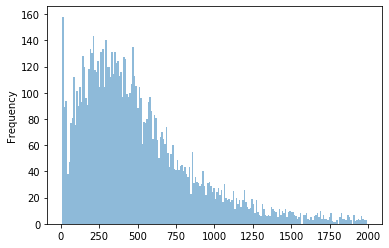

In [6]:
# histogram of sequence lengths
ax = df_data['Sequence_Length'].plot.hist(bins=200, alpha=0.5)

In [7]:
# count number of examples with sequence greater than 2000
count = 0
for i in range(len(df_data['Sequence_Length'])):
    if df_data['Sequence_Length'].iloc[i] > 2000:
        print(df_data['Sequence_Length'].iloc[i])
        count += 1
print(count)

0


In [8]:
cut_long_seq = False

if cut_long_seq:
    for n, i in enumerate(c_list):
        if c_list[n] > 2000:
            c_list[n] = float('NaN')
    for n, i in enumerate(n_list):
        if n_list[n] > 2000:
            n_list[n] = float('NaN')
    for n, i in enumerate(s_list):
        if s_list[n] > 2000:
            s_list[n] = float('NaN')
    for n, i in enumerate(m_list):
        if m_list[n] > 2000:
            m_list[n] = float('NaN')




# pad c_list 
c_list_new = np.append(c_list, np.repeat(np.nan, 310))
dfObj = pd.DataFrame(c_list_new, columns=['Cyto']) 
# pad s_list 
s_list_new = np.append(s_list, np.repeat(np.nan, 1709))
dfObj['Secreted'] = s_list_new
dfObj['Nuclear'] = n_list
# pad m_list 
m_list_new = np.append(m_list, np.repeat(np.nan, 2015))
dfObj['Mito'] = m_list_new
dfObj

,Cyto,Secreted,Nuclear,Mito
0,1182.0,1474.0,546,728.0
1,592.0,132.0,560,678.0
2,894.0,339.0,382,415.0
3,861.0,101.0,731,621.0
4,614.0,188.0,442,647.0
...,...,...,...,...
3309,NaN,NaN,614,NaN
3310,NaN,NaN,383,NaN
3311,NaN,NaN,337,NaN
3312,NaN,NaN,412,NaN


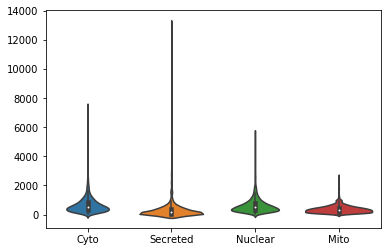

In [9]:
ax = sns.violinplot(data=dfObj)

## Data Preprocessing Function

In [10]:
def preprocess_data(df,categorical_cols,seed):
    # Impute missing values with mean of respective feature
    print("-----Missing Features Before Imputation------")
    print(df.isna().sum())
    df.fillna(df.mean(), inplace=True)
    print("-----Missing Features After Imputation------")
    print(df.isna().sum())
        
    # split columns into categorical and continuous
    continuous_cols = df.columns.difference(categorical_cols)
        
    # continuous columns need to be normalised
    scaler = StandardScaler()
    df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
        
    # encode the categorical columns
    for i in range(len(categorical_cols)):
        le = preprocessing.LabelEncoder()
        df[categorical_cols[i]] = le.fit_transform(df[categorical_cols[i]])
        if categorical_cols[i] == 'Subcellular_Location':
            le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            print("\n\n ------ INVERSE MAPPING ------")
            print(le_name_mapping)
    # shuffle the data    
    df = shuffle(df, random_state=seed)
    df.reset_index(inplace=True, drop=True)
    return df

In [11]:
categorical_cols = ['ID','Subcellular_Location']
df_data = preprocess_data(df_data,categorical_cols,seed)

-----Missing Features Before Imputation------
ID                              0
Sequence_Length                 0
Molar_Extinction_Coefficient    0
Isoelectric_Point               0
Aromaticity                     0
Secondary_Structure_Helix       0
Secondary_Structure_Turn        0
Secondary_Structure_Sheet       0
Mean_Flexibility                0
Gravy                           0
Molecular_Weight                0
Instability_Index               0
Subcellular_Location            0
dtype: int64
-----Missing Features After Imputation------
ID                              0
Sequence_Length                 0
Molar_Extinction_Coefficient    0
Isoelectric_Point               0
Aromaticity                     0
Secondary_Structure_Helix       0
Secondary_Structure_Turn        0
Secondary_Structure_Sheet       0
Mean_Flexibility                0
Gravy                           0
Molecular_Weight                0
Instability_Index               0
Subcellular_Location            0
dtype: int64

In [12]:
df_data

,ID,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,Molecular_Weight,Instability_Index,Subcellular_Location
0,5831,-0.467064,-0.412079,-1.087579,-0.346294,-0.618559,-0.386153,1.662142,0.031324,-0.108907,-0.482573,0.144234,2
1,129,-0.277188,-0.237655,-1.274681,-0.495080,-0.261606,-0.428909,0.052451,0.258900,-0.156911,-0.286089,-0.178052,2
2,591,1.244497,1.653182,-0.856997,1.136827,1.388790,-0.676516,0.156709,-0.434898,0.337770,1.337163,-0.341827,0
3,7104,1.953191,0.865456,-0.879436,-0.526125,-0.201071,-0.222576,0.857916,0.485277,-0.433857,1.991264,0.694963,0
4,956,-0.547294,-0.546911,1.133478,0.451617,-0.185935,-0.106073,-0.486471,1.090367,-1.090943,-0.518221,0.303567,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,3372,-1.242615,-1.169039,-1.631107,-1.750224,-3.088652,2.430601,-2.304548,1.023729,-1.004263,-1.249362,0.237287,3
9051,7943,-0.889606,-0.789793,1.502489,0.562841,1.265248,-1.465314,0.254557,-0.937986,1.013895,-0.873977,-0.431532,3
9052,8870,0.431506,1.257143,-1.004348,1.012324,1.280249,-0.480963,-0.087632,-0.731304,0.775369,0.460851,-0.162756,0
9053,6051,-0.068591,-0.016959,0.890578,0.226223,2.395100,-0.109899,0.540609,-2.291556,2.966908,-0.102127,0.149125,0


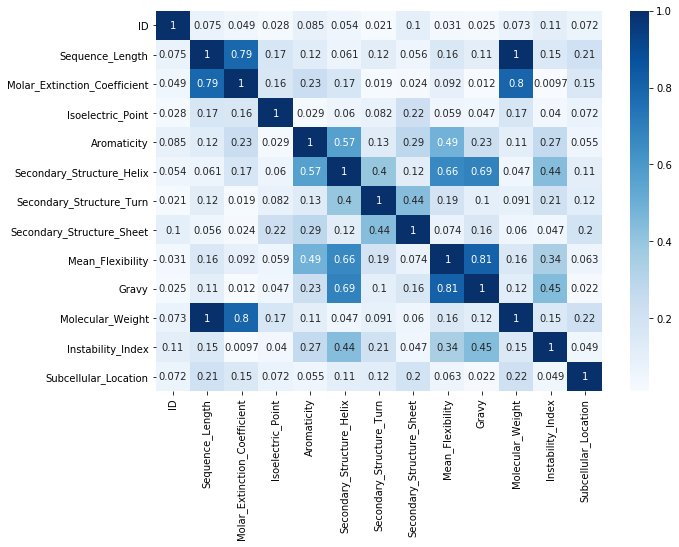

In [13]:
corrMatrix = df_data.corr()
plt.figure(figsize=(10,7))

sns.heatmap(abs(corrMatrix), annot=True, cmap='Blues')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

## Boxplot of Features; ignoring AA percentages

In [15]:
def boxplot_features(df_data,outliers):
        # variable names for indexing
        id_vars=[#'Contains_X',
                 'Sequence_Length', 
                   'Molar_Extinction_Coefficient',
                   'Isoelectric_Point', 
                   'Aromaticity',
                   'Secondary_Structure_Helix',
                   'Secondary_Structure_Turn',
                   'Secondary_Structure_Sheet',
                   'Mean_Flexibility',
                   'Gravy',
                   'Molecular_Weight',
                   'Instability_Index']

        # names to appear on plot
        short_names=[#'Contains X',
                     'Sequence \n Length',
                     'Molar \n Extinction \n Coefficient',
                     'Isoelectric \n Point', 
                     'Aromaticity',
                     'Secondary \n Structure \n Helix',
                     'Secondary \n Structure \n Turn',
                     'Secondary \n Structure \n Sheet',
                     'Mean \n Flexibility',
                     'Gravy',
                     'Molecular \n Weight',
                     'Instability \n Index']
        
        # arrange data in long dataframe for plotting
        # https://stackoverflow.com/questions/44552489/plotting-multiple-boxplots-in-seaborn
        df_list=[]
        for i in range(len(id_vars)):
                df_temp = df_data.filter(['Subcellular_Location',id_vars[i]], axis=1)
                experiment = i* np.ones((df_data.shape[0],1),dtype=int)
                df_temp['Feature'] = experiment
                df_temp = df_temp.rename(columns={id_vars[i]: "Standardised Value"})
                df_list.append(df_temp)
        cdf = pd.concat(df_list) 
        cdf = cdf.rename(columns={"Subcellular_Location": "Subcellular Location"})
        
        # rename features
        for i in range(len(id_vars)):
                cdf['Feature'][i*df_data.shape[0]:(i+1)*df_data.shape[0]] = short_names[i]
        
        # rename classes
        cdf['Subcellular Location'] = cdf['Subcellular Location'].replace(to_replace = 0, value = 'Cystolic') 
        cdf['Subcellular Location'] = cdf['Subcellular Location'].replace(to_replace = 1, value = 'Secreted') 
        cdf['Subcellular Location'] = cdf['Subcellular Location'].replace(to_replace = 2, value = 'Nucelear') 
        cdf['Subcellular Location'] = cdf['Subcellular Location'].replace(to_replace = 3, value = 'Mitochondrial') 
        
                
        # make boxplot 
        plt.figure(figsize=(30, 15))
        sns.set_style("darkgrid")       
        ax = sns.boxplot(x="Feature", y="Standardised Value", hue="Subcellular Location", notch=True, data=cdf, palette='pastel',showfliers = outliers) 
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles, ["Cyto", "Secreted","Nuclear","Mito"])
        ax.set_facecolor('w')
        plt.savefig('boxplot.png')
        plt.show()

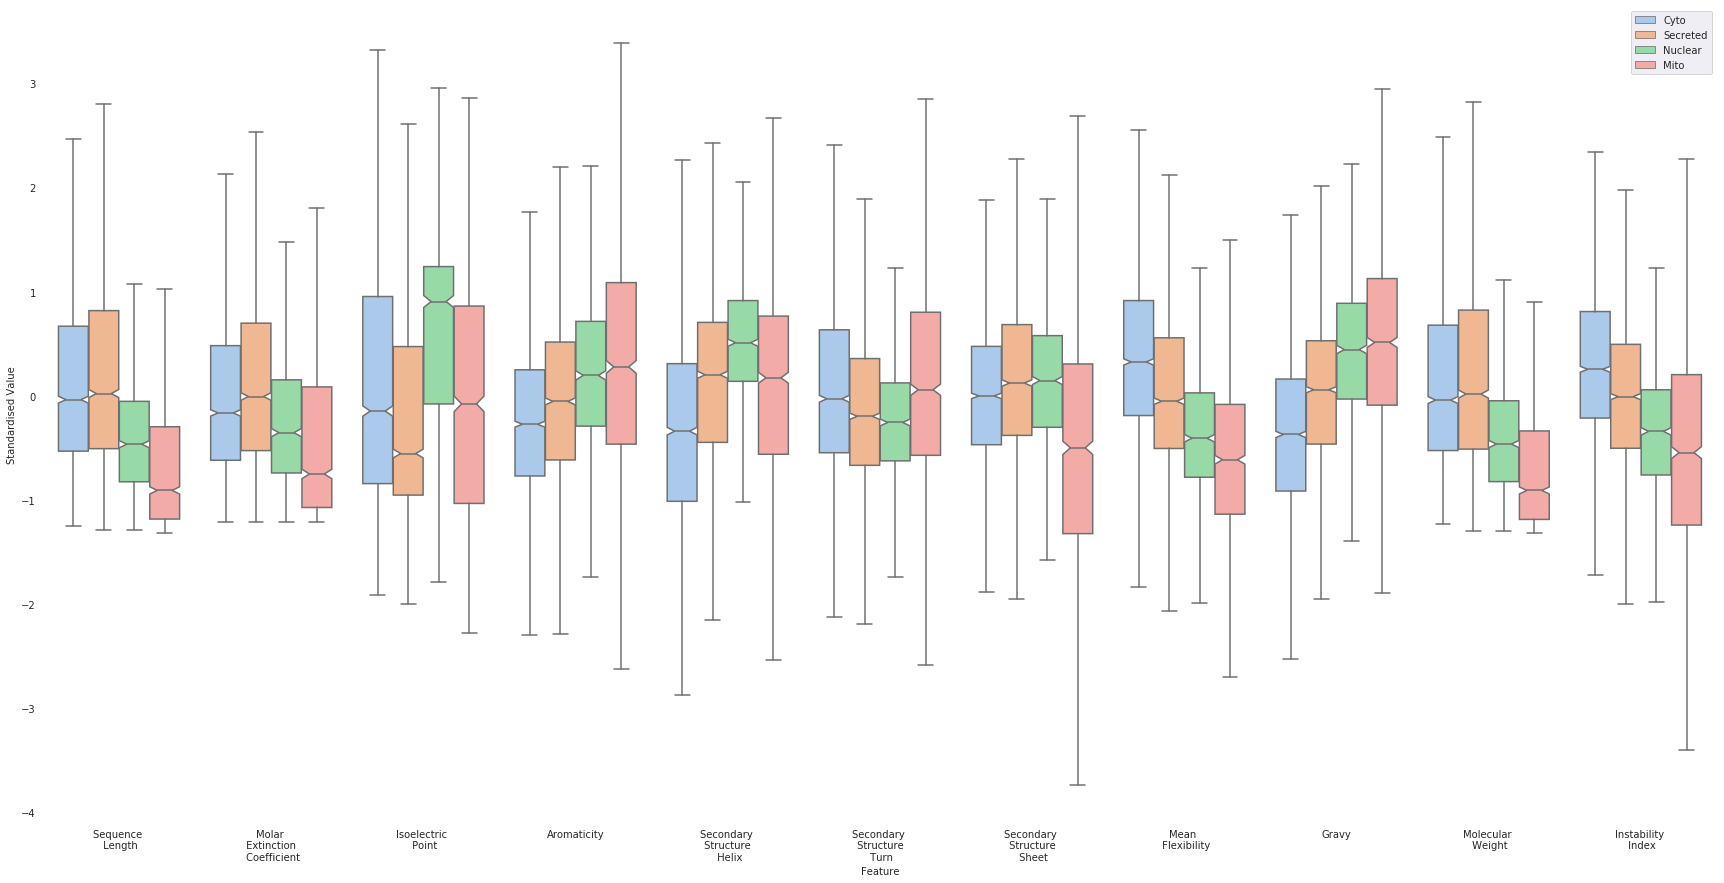

In [16]:
boxplot_features(df_data,outliers=False) 

## Correlation Plot; ignoring AA percentages

In [17]:
def correlation_plot(X,y):  
    pears_r = []
    X_plot = X.drop(['ID'],axis=1)
    for column in X_plot:
        inData = scipy.stats.pearsonr(X_plot[column], y)
        pears_r.append(inData[0])
        
    pears_df = pd.Series(pears_r, index = X_plot.columns)
    my_colors = []
    mx = max(pears_r) 
    mn = min(pears_r)
    plot_cvalues = []
    for x in range(len(pears_r)):
        plot_cvalues.append((pears_r[x] - mn)/(mx-mn))
    for x in range(len(pears_df)):
        my_colors.append((plot_cvalues[x], 0.1, 0.5+ 0.5*plot_cvalues[x]))
    print(my_colors)
    fig, ax = plt.subplots()
    pears_df.plot.bar(figsize=(20,20),yticks=np.arange(-0.35,0.2,0.1),color=my_colors,alpha=0.8)
    ax.set_xticklabels([#'Contains X',
                        'Sequence \n Length',
                        'Molar \n Extinction \n Coefficient',
                         #'Global Amino Acid \n Composition',
                         #'Local Amino Acid \n Composition (Start)',
                         #'Local Amino Acid \n Composition (End)',
                         'Isoelectric \n Point', 
                         'Aromaticity',
                         'Secondary Structure \n Helix',
                         'Secondary Structure \n Turn',
                         'Secondary Structure \n Sheet',
                         'Mean \n Flexibility',
                         'Gravy',
                         'Molecular \n Weight',
                         'Instability \n Index'])
    ax.set_facecolor('w')
    plt.xlabel('Feature',fontsize = 16)
    plt.ylabel('r value',fontsize = 16)
    plt.title('Pearson Correlation of Feature with Subcellular Location',fontsize = 20)
    fig.subplots_adjust(bottom=0.3) 
    plt.figure(figsize=(20, 2))
    plt.savefig('correlations.png')
    plt.show()

[(0.013885581915272904, 0.1, 0.5069427909576365), (0.18482347426236884, 0.1, 0.5924117371311844), (0.8579572771846355, 0.1, 0.9289786385923178), (0.8055809550377807, 0.1, 0.9027904775188904), (0.30502889513142883, 0.1, 0.6525144475657144), (1.0, 0.1, 1.0), (0.060691087336030965, 0.1, 0.5303455436680155), (0.45600125063562125, 0.1, 0.7280006253178106), (0.7085772450069762, 0.1, 0.854288622503488), (0.0, 0.1, 0.5), (0.49791508728284195, 0.1, 0.748957543641421)]


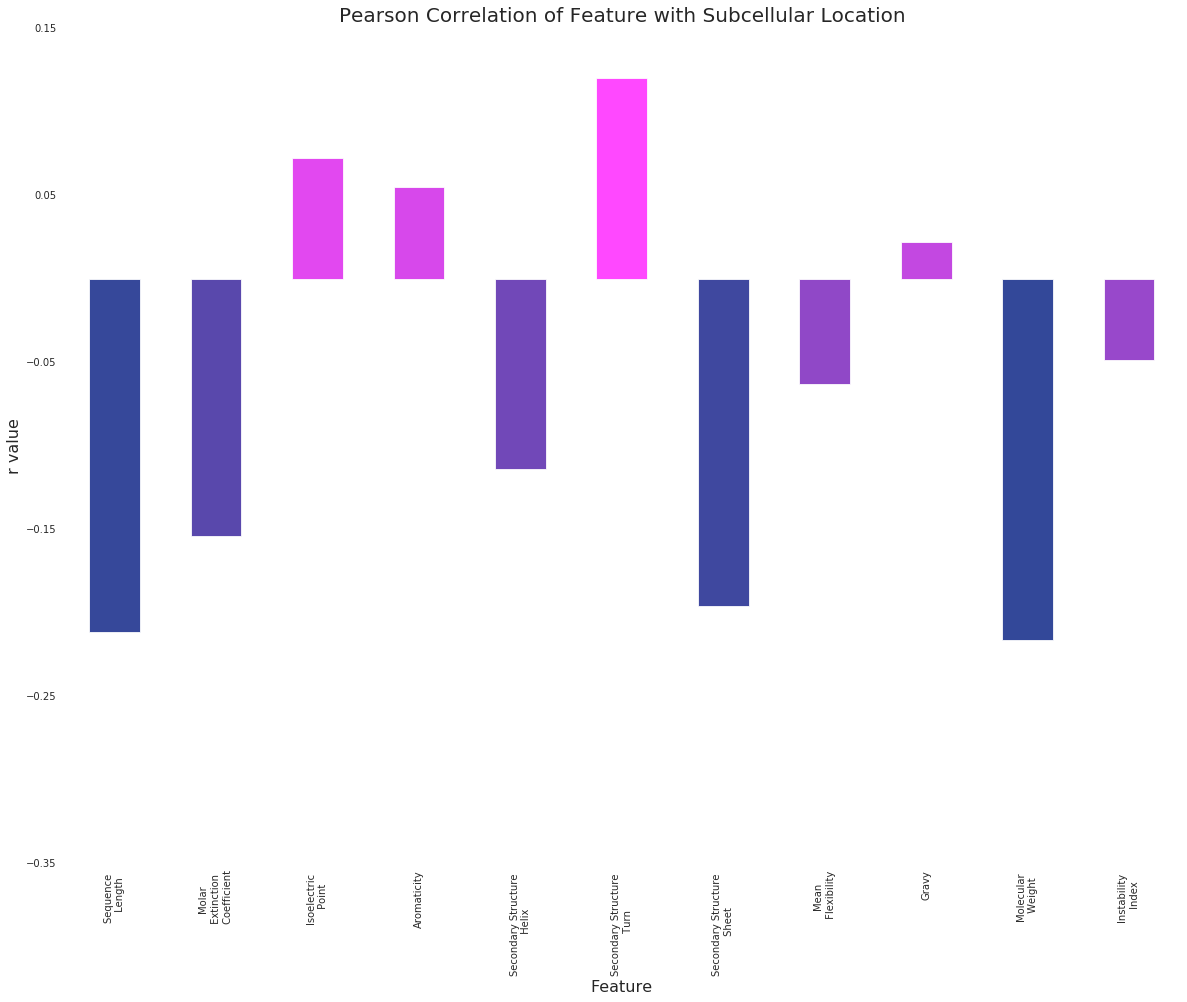

<Figure size 1440x144 with 0 Axes>

In [18]:
correlation_plot(df_data.drop(['Subcellular_Location'], axis=1),df_data['Subcellular_Location'])

## Generate Amino Acid Plots

In [19]:
# load data with long seq cut and all AA features included
df_c, c_list = load_data('cyto2.txt','cystolic',True,True)
df_s, s_list = load_data('secreted2.txt','secreted',True,True)
df_n, n_list = load_data('nuclear2.txt','nuclear',True,True)
df_m, m_list = load_data('mito2.txt','mitochondrial',True,True)
df_aa_plot = pd.concat([df_c,df_s,df_n,df_m])

---------- cyto2.txt ----------
Number of records = 2924
Max string length = 7393
Min string length = 19
Mean string length = 664.6654460719042
---------- secreted2.txt ----------
Number of records = 1586
Max string length = 13100
Min string length = 11
Mean string length = 304.7102803738318
---------- nuclear2.txt ----------
Number of records = 3248
Max string length = 5596
Min string length = 35
Mean string length = 624.4643934821968
---------- mito2.txt ----------
Number of records = 1297
Max string length = 2628
Min string length = 19
Mean string length = 375.56966897613546


In [20]:
df_aa_plot

,ID,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,...,Ne,Pe,Qe,Re,Se,Te,Ve,We,Ye,Subcellular_Location
0,sp|Q4JIM5|ABL2_MOUSE,1182,119680.0,7.965393,0.067682,0.241963,0.296108,0.252961,1.008064,-0.509983,...,3,2,4,2,6,2,7,0,0,cystolic
1,sp|P15891|ABP1_YEAST,592,60390.0,4.589172,0.060811,0.197635,0.285473,0.282095,1.025372,-1.042061,...,5,1,0,0,3,1,3,2,2,cystolic
2,sp|P35609|ACTN2_HUMAN,894,127052.5,5.307678,0.078300,0.282998,0.164430,0.313199,1.003840,-0.597315,...,0,5,2,3,5,0,1,0,4,cystolic
3,sp|P05095|ACTNA_DICDI,861,89060.0,5.001526,0.073171,0.298490,0.188153,0.295006,1.007373,-0.466783,...,1,1,3,1,4,1,2,0,3,cystolic
4,sp|Q9Y2D8|ADIP_HUMAN,614,66787.5,6.029358,0.061889,0.250814,0.214984,0.268730,1.012336,-0.882410,...,3,3,3,1,7,3,3,1,2,cystolic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,sp|P38851|YSP1_YEAST,1228,177502.5,8.361145,0.118078,0.350163,0.205212,0.236156,1.000323,-0.366775,...,3,1,2,3,2,4,1,1,3,mitochondrial
1293,sp|Q9HGM3|YTA12_SCHPO,773,42352.5,9.393005,0.078913,0.296248,0.253558,0.245796,1.003549,-0.305175,...,4,9,3,3,4,2,1,0,4,mitochondrial
1294,sp|P40341|YTA12_YEAST,825,69915.0,7.220154,0.077576,0.286061,0.223030,0.271515,1.009159,-0.570788,...,5,4,0,5,1,2,0,0,2,mitochondrial
1295,sp|P42844|ZIM17_YEAST,174,11647.5,9.491272,0.057471,0.258621,0.189655,0.212644,1.001064,-0.547126,...,4,3,5,0,5,0,3,0,1,mitochondrial


In [21]:
def plot_preprocess_data(df,categorical_cols,seed):
    # Impute missing values with mean of respective feature
    df.fillna(df.mean(), inplace=True)
    
    # split columns into categorical and continuous
    continuous_cols = df.columns.difference(categorical_cols)
               
    # encode the categorical columns
    for i in range(len(categorical_cols)):
        le = preprocessing.LabelEncoder()
        df[categorical_cols[i]] = le.fit_transform(df[categorical_cols[i]])
        if categorical_cols[i] == 'Subcellular_Location':
            le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            #print("\n\n ------ INVERSE MAPPING ------")
            #print(le_name_mapping)
    # shuffle the data    
    #df = shuffle(df, random_state=seed)
    df.reset_index(inplace=True, drop=True)
    return df

In [22]:
def aa_plot(df,subject,region):
    if region == 'end':
        q=df[['Ae', 'Ce', 'De', 'Ee', 'Fe','Ge', 'He', 'Ie', 'Ke', 'Le','Me', 'Ne', 'Pe', 'Qe', 'Re','Se', 'Te', 'Ve', 'We', 'Ye','Subcellular_Location']].copy()
    if region == 'start':
        q=df[['As', 'Cs', 'Ds', 'Es', 'Fs','Gs', 'Hs', 'Is', 'Ks', 'Ls','Ms', 'Ns', 'Ps', 'Qs', 'Rs','Ss', 'Ts', 'Vs', 'Ws', 'Ys','Subcellular_Location']].copy()
    if region == 'global':
        q=df[['Ag', 'Cg', 'Dg', 'Eg', 'Fg','Gg', 'Hg', 'Ig', 'Kg', 'Lg','Mg', 'Ng', 'Pg', 'Qg', 'Rg','Sg', 'Tg', 'Vg', 'Wg', 'Yg','Subcellular_Location']].copy()
       
    
    
    q=plot_preprocess_data(q,['Subcellular_Location'],1)
    

    
    r=q.groupby('Subcellular_Location').mean()
    s=r.transpose()
    
    # what to plot
    if subject == 'count':
        s.plot.bar(width=0.8, figsize=(20,10),align='edge')
        l = plt.legend(('Cyto','Mito','Nuclear','Secreted'), loc='best')
        plt.xlabel('Amino Acid')
        plt.ylabel('Count across Locations')
    if subject == 'std':
        plt.figure(figsize=(10,7))
        t=s.std(axis=1)
        t.plot.bar()
        plt.xlabel('Amino Acid')
        plt.ylabel('Standard Deviation across Locations')
        
        
        
  #  corrMatrix = q.corr()
  #  plt.figure(figsize=(20,20))

#    sns.heatmap(abs(corrMatrix), annot=True, cmap='Blues')

    # fix for mpl bug that cuts off top/bottom of seaborn viz
#    b, t = plt.ylim() # discover the values for bottom and top
#    b += 0.5 # Add 0.5 to the bottom
#    t -= 0.5 # Subtract 0.5 from the top
#    plt.ylim(b, t) # update the ylim(bottom, top) values

#    plt.show()

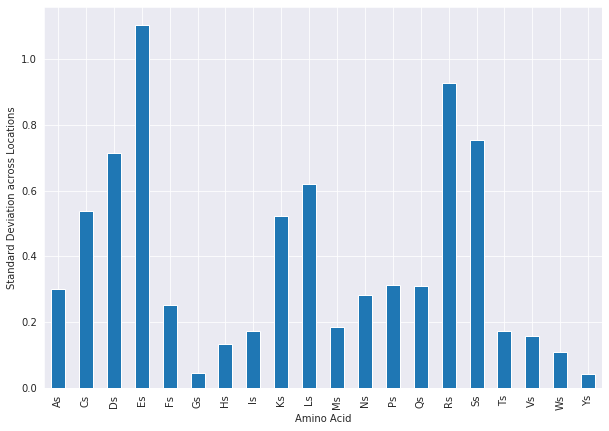

In [23]:
aa_plot(df_aa_plot,'std','start')

## Reload and Preprocess Data Including AA Percentages

In [24]:
### Set random seed ###
seed = 2020

### Load data from each subcellular location ###

cut_long_seq = True
inc_aa_count_feature = True

df_cystolic, _ = load_data('cyto2.txt','cystolic',cut_long_seq,inc_aa_count_feature)
df_secreted, _ = load_data('secreted2.txt','secreted',cut_long_seq,inc_aa_count_feature)
df_nuclear, _ = load_data('nuclear2.txt','nuclear',cut_long_seq,inc_aa_count_feature)
df_mitochondrial, _ = load_data('mito2.txt','mitochondrial',cut_long_seq,inc_aa_count_feature)

### Concatenate data and shuffle ###
df_data = pd.concat([df_cystolic,df_secreted,df_nuclear,df_mitochondrial])
num_records = len(df_data)
print("Number cystolic records = {}".format(len(df_cystolic)))
print("Number of secreted records = {}".format(len(df_secreted)))
print("Number of nuclear records = {}".format(len(df_nuclear)))
print("Number of mitochondrial records = {}".format(len(df_mitochondrial)))
print("Total number of records = {}".format(num_records))


categorical_cols = ['ID','Subcellular_Location']
df_data = preprocess_data(df_data,categorical_cols,seed)

---------- cyto2.txt ----------
Number of records = 2924
Max string length = 7393
Min string length = 19
Mean string length = 664.6654460719042
---------- secreted2.txt ----------
Number of records = 1586
Max string length = 13100
Min string length = 11
Mean string length = 304.7102803738318
---------- nuclear2.txt ----------
Number of records = 3248
Max string length = 5596
Min string length = 35
Mean string length = 624.4643934821968
---------- mito2.txt ----------
Number of records = 1297
Max string length = 2628
Min string length = 19
Mean string length = 375.56966897613546
Number cystolic records = 2924
Number of secreted records = 1586
Number of nuclear records = 3248
Number of mitochondrial records = 1297
Total number of records = 9055
-----Missing Features Before Imputation------
ID                              0
Sequence_Length                 0
Molar_Extinction_Coefficient    0
Isoelectric_Point               0
Aromaticity                     0
                               

In [25]:
df_data

,ID,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,...,Ne,Pe,Qe,Re,Se,Te,Ve,We,Ye,Subcellular_Location
0,5831,-0.467064,-0.412122,-1.087001,-0.345612,-0.618647,-0.387055,1.659587,0.031473,-0.108118,...,-0.682757,-0.708496,-0.093184,1.376535,-0.399516,-1.410233,0.680395,0.478102,-0.284615,2
1,129,-0.277188,-0.237691,-1.274085,-0.494124,-0.261659,-0.429878,0.051924,0.258738,-0.156050,...,-0.682757,-1.147969,-1.114098,0.071213,0.328668,-0.290431,-0.946194,-0.688802,-0.284615,2
2,591,1.244497,1.653226,-0.856441,1.134772,1.388896,-0.677865,0.156050,-0.434112,0.337899,...,0.946182,0.170451,-0.603641,-0.363895,-0.035424,-0.290431,0.138199,-0.688802,-0.284615,0
3,7104,1.953191,0.865467,-0.878878,-0.525111,-0.201118,-0.223227,0.856375,0.484807,-0.432588,...,-0.139778,-0.708496,0.927729,-0.363895,0.692759,-0.290431,-0.946194,-0.688802,-0.988957,0
4,956,-0.547294,-0.546960,1.133840,0.450826,-0.185981,-0.106545,-0.486319,1.089070,-1.088703,...,0.403202,0.170451,-0.603641,0.071213,0.328668,-0.850332,0.680395,-0.688802,-0.284615,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,3372,-1.242615,-1.169114,-1.630477,-1.746953,-3.088980,2.434029,-2.302105,1.022523,-1.002151,...,2.032141,1.049397,0.927729,-0.799002,-0.763607,0.829371,-0.403998,-0.688802,-0.284615,3
9051,7943,-0.889606,-0.789852,1.502815,0.561845,1.265343,-1.467876,0.253775,-0.936514,1.013025,...,-0.682757,-1.147969,-0.603641,0.506320,1.420943,-0.850332,-1.488391,0.478102,0.419727,3
9052,8870,0.431506,1.257170,-1.003778,1.010499,1.280346,-0.482012,-0.087983,-0.730113,0.774852,...,-0.682757,0.170451,-1.114098,0.071213,-1.127699,0.269470,0.680395,1.645006,-0.284615,0
9053,6051,-0.068591,-0.016986,0.890963,0.225848,2.395305,-0.110377,0.539467,-2.288235,2.963153,...,-0.139778,-0.269023,-0.093184,-1.234110,0.692759,0.829371,0.138199,-0.688802,-0.284615,0


## Split Features and Labels

In [26]:
y = df_data['Subcellular_Location']
X = df_data.drop(['Subcellular_Location'], axis=1)

## Drop ID Tag 
This is definitely unrelated to subcellular location

In [27]:
X = X.drop(columns=['ID'])
X

,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,Molecular_Weight,...,Me,Ne,Pe,Qe,Re,Se,Te,Ve,We,Ye
0,-0.467064,-0.412122,-1.087001,-0.345612,-0.618647,-0.387055,1.659587,0.031473,-0.108118,-0.482574,...,-0.899821,-0.682757,-0.708496,-0.093184,1.376535,-0.399516,-1.410233,0.680395,0.478102,-0.284615
1,-0.277188,-0.237691,-1.274085,-0.494124,-0.261659,-0.429878,0.051924,0.258738,-0.156050,-0.286089,...,0.001593,-0.682757,-1.147969,-1.114098,0.071213,0.328668,-0.290431,-0.946194,-0.688802,-0.284615
2,1.244497,1.653226,-0.856441,1.134772,1.388896,-0.677865,0.156050,-0.434112,0.337899,1.337163,...,0.903007,0.946182,0.170451,-0.603641,-0.363895,-0.035424,-0.290431,0.138199,-0.688802,-0.284615
3,1.953191,0.865467,-0.878878,-0.525111,-0.201118,-0.223227,0.856375,0.484807,-0.432588,1.991264,...,-0.899821,-0.139778,-0.708496,0.927729,-0.363895,0.692759,-0.290431,-0.946194,-0.688802,-0.988957
4,-0.547294,-0.546960,1.133840,0.450826,-0.185981,-0.106545,-0.486319,1.089070,-1.088703,-0.518221,...,-0.899821,0.403202,0.170451,-0.603641,0.071213,0.328668,-0.850332,0.680395,-0.688802,-0.284615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,-1.242615,-1.169114,-1.630477,-1.746953,-3.088980,2.434029,-2.302105,1.022523,-1.002151,-1.249362,...,-0.899821,2.032141,1.049397,0.927729,-0.799002,-0.763607,0.829371,-0.403998,-0.688802,-0.284615
9051,-0.889606,-0.789852,1.502815,0.561845,1.265343,-1.467876,0.253775,-0.936514,1.013025,-0.873977,...,0.903007,-0.682757,-1.147969,-0.603641,0.506320,1.420943,-0.850332,-1.488391,0.478102,0.419727
9052,0.431506,1.257170,-1.003778,1.010499,1.280346,-0.482012,-0.087983,-0.730113,0.774852,0.460851,...,0.903007,-0.682757,0.170451,-1.114098,0.071213,-1.127699,0.269470,0.680395,1.645006,-0.284615
9053,-0.068591,-0.016986,0.890963,0.225848,2.395305,-0.110377,0.539467,-2.288235,2.963153,-0.102127,...,0.903007,-0.139778,-0.269023,-0.093184,-1.234110,0.692759,0.829371,0.138199,-0.688802,-0.284615


## Feature Selection (Recursive Feature Elimination)

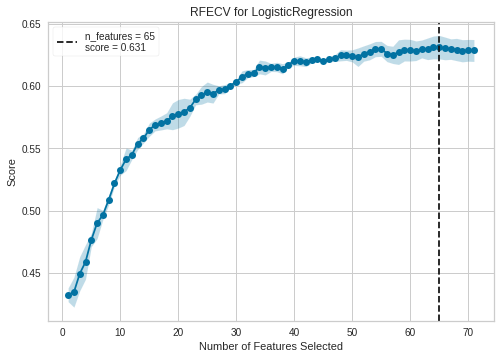

In [28]:
from yellowbrick.model_selection import RFECV

lr = True

if lr == False:
    svc = SVC(kernel='linear',probability=True,random_state=1)
    visualizer = RFECV(svc)


if lr == True:
    #visualizer = RFECV(LogisticRegression(class_weight='balanced'))
    visualizer = RFECV(LogisticRegression())
    
visualizer.fit(X,y)
visualizer.show()

## Remove Features That Aren't Useful

In [291]:
# drop redundant features
temp = pd.Series(visualizer.support_, index=list(X.columns))
deselect = temp[temp==False].index

#deselect = ['Cs', 'Fs', 'Is', 'Vs', 'Ws', 'Wg']

X_reduced = X.drop(columns=deselect)
print("Redundant features = {}".format(deselect))
X_reduced

Redundant features = Index(['Wg', 'Cs', 'Fs', 'Is', 'Vs', 'Ws'], dtype='object')


,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,Molecular_Weight,...,Me,Ne,Pe,Qe,Re,Se,Te,Ve,We,Ye
0,-0.467064,-0.412122,-1.087001,-0.345612,-0.618647,-0.387055,1.659587,0.031473,-0.108118,-0.482574,...,-0.899821,-0.682757,-0.708496,-0.093184,1.376535,-0.399516,-1.410233,0.680395,0.478102,-0.284615
1,-0.277188,-0.237691,-1.274085,-0.494124,-0.261659,-0.429878,0.051924,0.258738,-0.156050,-0.286089,...,0.001593,-0.682757,-1.147969,-1.114098,0.071213,0.328668,-0.290431,-0.946194,-0.688802,-0.284615
2,1.244497,1.653226,-0.856441,1.134772,1.388896,-0.677865,0.156050,-0.434112,0.337899,1.337163,...,0.903007,0.946182,0.170451,-0.603641,-0.363895,-0.035424,-0.290431,0.138199,-0.688802,-0.284615
3,1.953191,0.865467,-0.878878,-0.525111,-0.201118,-0.223227,0.856375,0.484807,-0.432588,1.991264,...,-0.899821,-0.139778,-0.708496,0.927729,-0.363895,0.692759,-0.290431,-0.946194,-0.688802,-0.988957
4,-0.547294,-0.546960,1.133840,0.450826,-0.185981,-0.106545,-0.486319,1.089070,-1.088703,-0.518221,...,-0.899821,0.403202,0.170451,-0.603641,0.071213,0.328668,-0.850332,0.680395,-0.688802,-0.284615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,-1.242615,-1.169114,-1.630477,-1.746953,-3.088980,2.434029,-2.302105,1.022523,-1.002151,-1.249362,...,-0.899821,2.032141,1.049397,0.927729,-0.799002,-0.763607,0.829371,-0.403998,-0.688802,-0.284615
9051,-0.889606,-0.789852,1.502815,0.561845,1.265343,-1.467876,0.253775,-0.936514,1.013025,-0.873977,...,0.903007,-0.682757,-1.147969,-0.603641,0.506320,1.420943,-0.850332,-1.488391,0.478102,0.419727
9052,0.431506,1.257170,-1.003778,1.010499,1.280346,-0.482012,-0.087983,-0.730113,0.774852,0.460851,...,0.903007,-0.682757,0.170451,-1.114098,0.071213,-1.127699,0.269470,0.680395,1.645006,-0.284615
9053,-0.068591,-0.016986,0.890963,0.225848,2.395305,-0.110377,0.539467,-2.288235,2.963153,-0.102127,...,0.903007,-0.139778,-0.269023,-0.093184,-1.234110,0.692759,0.829371,0.138199,-0.688802,-0.284615


## Train/Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=2020)

## Train and Cross-Validate Different Models
Note we use 10-fold CV on (X_train,y_train) to grid search the best parameters.

We then run each mclassifer (with its best parameters) once on (X_test,y_test) to get a score. We will use these test scores to compare the different classifiers and identify which is best for making the blind predictions.

In [199]:
y_bin = label_binarize(y, classes=[0,1,2,3])

In [200]:
y_bin

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

In [294]:
### SVM rbf ###
best_acc = 0
best_C_idx = 0
C_list = [0.1,0.5,1.0,5.0,10.0,20.0]
C_num = len(C_list)

print("Running 10-fold CV")
for i in range(C_num):
    clf = SVC(kernel='rbf', C=C_list[i], class_weight='balanced',decision_function_shape='ovr')
    #clf_acc = cross_val_score(clf, X_reduced, y, cv=10)
    clf_acc = cross_val_score(clf, X_train, y_train, cv=10)
    print("C = {}, mean acc = {}, best acc = {}".format(C_list[i],clf_acc.mean(), best_acc))
    if clf_acc.mean() > best_acc:
        best_acc = clf_acc.mean()
        best_C_idx_rbf = i
print("10-fold CV complete \n best C = {}".format(C_list[best_C_idx_rbf]))

#best_C_idx_rbf = 2


print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_svmr = SVC(kernel='rbf', C=C_list[best_C_idx_rbf],probability=True, class_weight='balanced',decision_function_shape='ovr')
#clf_svmr_acc = cross_val_score(clf_svmr, X_test, y_test, cv=10)
clf_svmr.fit(X_train,y_train)
y_pred_svmr = clf_svmr.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_svmr, target_names=target_names,digits=5))
    
#SVMrbf_results = pd.DataFrame({'Model': 'SVM rbf', 'Accuracy': clf_svmr_acc.mean(), 'Acc_Std': clf_svmr_acc.std()}, index=[0])

Running 10-fold CV
C = 0.1, mean acc = 0.6194164680602453, best acc = 0
C = 0.5, mean acc = 0.6486684132230469, best acc = 0.6194164680602453
C = 1.0, mean acc = 0.6535036383438138, best acc = 0.6486684132230469
C = 5.0, mean acc = 0.6493666373235735, best acc = 0.6535036383438138
C = 10.0, mean acc = 0.6409492024358391, best acc = 0.6535036383438138
C = 20.0, mean acc = 0.6344555667074501, best acc = 0.6535036383438138
10-fold CV complete 
 best C = 1.0


 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.56884   0.56987   0.56936       551
        mito    0.60684   0.80682   0.69268       264
     nuclear    0.69611   0.60522   0.64749       651
    secreted    0.82164   0.81449   0.81805       345

    accuracy                        0.66372      1811
   macro avg    0.67336   0.69910   0.68190      1811
weighted avg    0.66829   0.66372   0.66280      1811



In [339]:
### SVM polynomial ###
best_acc = 0
best_C_idx_poly = 0
C_list = [1.0,10.0,100.0]
deg_list=[2,3,4,5]
C_num = len(C_list)
d_num = len(deg_list)

print("Running 10-fold CV")
for i in range(C_num):
    for j in range(d_num):
        clf = SVC(kernel='poly', C=C_list[i], degree=deg_list[j], class_weight='balanced',decision_function_shape='ovr')
        #clf_acc = cross_val_score(clf, X_reduced, y, cv=10)
        clf_acc = cross_val_score(clf, X_train, y_train, cv=10)
        print("C = {}, deg = {}, mean acc = {}, best acc = {}".format(C_list[i],deg_list[j],clf_acc.mean(), best_acc))
        if clf_acc.mean() > best_acc:
            best_acc = clf_acc.mean()
            best_C_idx_poly = i
            best_d_idx = j
print("10-fold CV complete \n best C = {}, best deg = {}".format(C_list[best_C_idx_poly],deg_list[best_d_idx]))


#best_C_idx_poly = 1
#best_d_idx = 1
print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_svmp = SVC(kernel='poly', C=C_list[best_C_idx_poly],degree=deg_list[best_d_idx],probability=True, class_weight='balanced',decision_function_shape='ovr')
#clf_svmp_acc = cross_val_score(clf_svmp, X_reduced, y, cv=10)
clf_svmp.fit(X_train,y_train)
y_pred_svmp = clf_svmp.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_svmp, target_names=target_names,digits=5))

#SVMpoly_results = pd.DataFrame({'Model': 'SVM poly', 'Accuracy': clf_svmp_acc.mean(), 'Acc_Std': clf_svmp_acc.std()}, index=[0])

Running 10-fold CV
C = 1.0, deg = 2, mean acc = 0.5821244951506097, best acc = 0
C = 1.0, deg = 3, mean acc = 0.6141741109978207, best acc = 0.5821244951506097


KeyboardInterrupt: 

In [296]:
### Logistic Regression ###
clf_lr = LogisticRegression(multi_class='ovr')
#clf_lr_acc = cross_val_score(clf_lr, X_reduced, y, cv=10)

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_lr.fit(X_train,y_train)
y_pred_lr = clf_lr.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_lr, target_names=target_names,digits=5))

#LogReg_results = pd.DataFrame({'Model': 'Logistic Regression', 'Accuracy': clf_lr_acc.mean(), 'Acc_Std': clf_lr_acc.std()}, index=[0])



 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.53208   0.51180   0.52174       551
        mito    0.66540   0.66288   0.66414       264
     nuclear    0.62093   0.67435   0.64654       651
    secreted    0.81029   0.73043   0.76829       345

    accuracy                        0.63390      1811
   macro avg    0.65717   0.64486   0.65018      1811
weighted avg    0.63645   0.63390   0.63433      1811



In [340]:
### KNN ###
best_acc = 0
best_neighbors = 0

print("Running 10-fold CV")
for i in range(1,25):
    clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=i))
    #clf_acc = cross_val_score(clf, X_reduced, y, cv=10)
    clf_acc = cross_val_score(clf, X_train, y_train, cv=10)
    print("i = {}, mean acc = {}, best acc = {}".format(i,clf_acc.mean(), best_acc))
    if clf_acc.mean() > best_acc:
        best_acc = clf_acc.mean()
        best_neighbors = i
print("10-fold CV complete \n best n = {}".format(best_neighbors))

#best_neighbors = 18

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_knn = OneVsRestClassifier(KNeighborsClassifier(best_neighbors))
#clf_knn_acc = cross_val_score(clf_knn, X_reduced, y, cv=10)
clf_knn.fit(X_train,y_train)
y_pred_knn = clf_knn.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_knn, target_names=target_names,digits=5))


#KNN_results = pd.DataFrame({'Model': 'KNN', 'Accuracy': clf_knn_acc.mean(), 'Acc_Std': clf_knn_acc.std()}, index=[0])

Running 10-fold CV
i = 1, mean acc = 0.5585157362851293, best acc = 0
i = 2, mean acc = 0.5496881191350039, best acc = 0.5585157362851293
i = 3, mean acc = 0.5727485898579031, best acc = 0.5585157362851293
i = 4, mean acc = 0.5891755808792869, best acc = 0.5727485898579031
i = 5, mean acc = 0.5861363274123308, best acc = 0.5891755808792869
i = 6, mean acc = 0.5951211022415954, best acc = 0.5891755808792869
i = 7, mean acc = 0.5992459130611776, best acc = 0.5951211022415954
i = 8, mean acc = 0.6064309206736226, best acc = 0.5992459130611776
i = 9, mean acc = 0.6067056464774833, best acc = 0.6064309206736226
i = 10, mean acc = 0.6062876663046376, best acc = 0.6067056464774833
i = 11, mean acc = 0.6029782530266864, best acc = 0.6067056464774833
i = 12, mean acc = 0.6085002777276323, best acc = 0.6067056464774833
i = 13, mean acc = 0.6123608430573443, best acc = 0.6085002777276323
i = 14, mean acc = 0.6112625271134373, best acc = 0.6123608430573443
i = 15, mean acc = 0.6086374488223762, be

In [299]:
### MLP ###

clf_mlp = OneVsRestClassifier(MLPClassifier(solver='adam', activation = 'logistic', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=2020))
#clf_mlp_acc = cross_val_score(clf_mlp, X_reduced, y, cv=10)

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_mlp.fit(X_train,y_train)
y_pred_mlp = clf_mlp.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_mlp, target_names=target_names,digits=5))


#MLP_results = pd.DataFrame({'Model': 'MLP', 'Accuracy': clf_mlp_acc.mean(), 'Acc_Std': clf_mlp_acc.std()}, index=[0])



 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.51635   0.54446   0.53004       551
        mito    0.64639   0.64394   0.64516       264
     nuclear    0.62861   0.63441   0.63150       651
    secreted    0.82903   0.74493   0.78473       345

    accuracy                        0.62949      1811
   macro avg    0.65510   0.64194   0.64786      1811
weighted avg    0.63523   0.62949   0.63181      1811



In [341]:
### Decision Tree ###
clf_dt = OneVsRestClassifier(tree.DecisionTreeClassifier(random_state=2020))
#clf_dt_acc = cross_val_score(clf_dt, X_reduced, y, cv=10)

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_dt.fit(X_train,y_train)
y_pred_dt = clf_dt.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_dt, target_names=target_names,digits=5))


#DT_results = pd.DataFrame({'Model': 'Decision Tree', 'Accuracy': clf_dt_acc.mean(), 'Acc_Std': clf_dt_acc.std()}, index=[0])



 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.50000   0.27042   0.35100       551
        mito    0.58537   0.36364   0.44860       264
     nuclear    0.58305   0.52842   0.55439       651
    secreted    0.37022   0.81449   0.50906       345

    accuracy                        0.48040      1811
   macro avg    0.50966   0.49424   0.46576      1811
weighted avg    0.51758   0.48040   0.46845      1811



In [342]:
### Random Forest ###
best_acc = 0
best_depth_idx = 0
d_list = [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
d_num = len(d_list)

print("Running 10-fold CV")
for i in range(d_num):
    clf_rf = OneVsRestClassifier(RandomForestClassifier(max_depth=d_list[i], random_state=2020))
    #clf_rf_acc = cross_val_score(clf_rf, X_reduced, y, cv=10)
    clf_rf_acc = cross_val_score(clf_rf, X_train, y_train, cv=10)
    print("max depth = {}, mean acc = {}, best acc = {}".format(d_list[i],clf_rf_acc.mean(), best_acc))
    if clf_rf_acc.mean() > best_acc:
        best_acc = clf_rf_acc.mean()
        best_d_idx = i
print("10-fold CV complete \n best max depth = {}".format(d_list[best_d_idx]))


#best_depth_idx=12

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_rf = OneVsRestClassifier(RandomForestClassifier(max_depth=d_list[best_d_idx], random_state=2020))
#clf_rf_acc = cross_val_score(clf_rf, X_reduced, y, cv=10)
clf_rf.fit(X_train,y_train)
y_pred_rf = clf_rf.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_rf, target_names=target_names,digits=5))


#RF_results = pd.DataFrame({'Model': 'Random Forest', 'Accuracy': clf_rf_acc.mean(), 'Acc_Std': clf_rf_acc.std()}, index=[0])

Running 10-fold CV
max depth = None, mean acc = 0.6067020136130432, best acc = 0
max depth = 1, mean acc = 0.48550140257381297, best acc = 0.6067020136130432
max depth = 2, mean acc = 0.5035870031147793, best acc = 0.6067020136130432
max depth = 3, mean acc = 0.5336815855799589, best acc = 0.6067020136130432
max depth = 4, mean acc = 0.5662560941422757, best acc = 0.6067020136130432
max depth = 5, mean acc = 0.5782704046775428, best acc = 0.6067020136130432
max depth = 6, mean acc = 0.5920673866381063, best acc = 0.6067020136130432
max depth = 7, mean acc = 0.5977349502833084, best acc = 0.6067020136130432
max depth = 8, mean acc = 0.6087755609353964, best acc = 0.6067020136130432
max depth = 9, mean acc = 0.6103082154999333, best acc = 0.6087755609353964
max depth = 10, mean acc = 0.6138883522169257, best acc = 0.6103082154999333
max depth = 11, mean acc = 0.6129218708538285, best acc = 0.6138883522169257
max depth = 12, mean acc = 0.6234135935479583, best acc = 0.6138883522169257
max

In [343]:
### XGBoost ###
best_acc = 0
best_depth_idx = 0
d_list = [None,1,2,3,4,5,6,7]
c_list = [None,1,2,3,4,5,6,7]
d_num = len(d_list)
c_num = len(c_list)

print("Running 10-fold CV")
for i in range(d_num):
    for j in range(c_num):
        clf_xg = OneVsRestClassifier(xgb.XGBClassifier(max_depth=d_list[i],min_child_weight=c_list[j],random_state=2020))
        #clf_xg_acc = cross_val_score(clf_xg, X_reduced, y, cv=10)
        clf_xg_acc = cross_val_score(clf_xg, X_train, y_train, cv=10)
        print("max depth = {}, min child weight = {}, mean acc = {}, best acc = {}".format(d_list[i],c_list[j],clf_xg_acc.mean(), best_acc))
        if clf_xg_acc.mean() > best_acc:
            best_acc = clf_xg_acc.mean()
            best_d_idx = i
            best_c_idx = j
print("10-fold CV complete \n best max depth = {}, best min child weight = {}".format(d_list[best_d_idx], c_list[best_c_idx]))

#best_d_idx=0
#best_c_idx=4

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_xg = OneVsRestClassifier(xgb.XGBClassifier(max_depth=d_list[best_d_idx],min_child_weight=c_list[best_c_idx],random_state=0))
#clf_xg_acc = cross_val_score(clf_xg, X_reduced, y, cv=10)
clf_xg.fit(X_train,y_train)
y_pred_xg = clf_xg.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_xg, target_names=target_names,digits=5))

#XG_results = pd.DataFrame({'Model': 'XG Boost', 'Accuracy': clf_xg_acc.mean(), 'Acc_Std': clf_xg_acc.std()}, index=[0])

Running 10-fold CV
max depth = None, min child weight = None, mean acc = 0.656391441650945, best acc = 0
max depth = None, min child weight = 1, mean acc = 0.656391441650945, best acc = 0.656391441650945
max depth = None, min child weight = 2, mean acc = 0.6558539829281335, best acc = 0.656391441650945
max depth = None, min child weight = 3, mean acc = 0.6599932496427322, best acc = 0.656391441650945
max depth = None, min child weight = 4, mean acc = 0.66799520674314, best acc = 0.6599932496427322
max depth = None, min child weight = 5, mean acc = 0.660412383911928, best acc = 0.66799520674314
max depth = None, min child weight = 6, mean acc = 0.6579233273905245, best acc = 0.66799520674314
max depth = None, min child weight = 7, mean acc = 0.6557122536782527, best acc = 0.66799520674314
max depth = 1, min child weight = None, mean acc = 0.6274225996753564, best acc = 0.66799520674314
max depth = 1, min child weight = 1, mean acc = 0.6274225996753564, best acc = 0.66799520674314
max de

In [344]:
### AdaBoost ###
best_acc = 0
best_E_idx = 0
E_list = [100,200,300,400,500]
E_num = len(E_list)

print("Running 10-fold CV")
for i in range(E_num):
    clf_ada = OneVsRestClassifier(AdaBoostClassifier(n_estimators=E_list[i],random_state=2020))
    #clf_ada_acc = cross_val_score(clf_ada, X_reduced, y, cv=10)
    clf_ada_acc = cross_val_score(clf_ada, X_train, y_train, cv=10)
    print("num estimators = {}, mean_acc = {}, best_acc = {}".format(E_list[i], clf_ada_acc.mean(),best_acc))
    if clf_ada_acc.mean() > best_acc:
        best_acc = clf_ada_acc.mean()
        best_E_idx = i
print("10-fold CV complete \n best num estimators = {}".format(E_list[best_E_idx]))

#best_E_idx = 2

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_ada = OneVsRestClassifier(AdaBoostClassifier(n_estimators=E_list[best_E_idx],random_state=2020))
#clf_ada_acc = cross_val_score(clf_ada, X_reduced, y, cv=10)
clf_ada.fit(X_train,y_train)
y_pred_ada = clf_ada.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_ada, target_names=target_names,digits=5))

#Ada_results = pd.DataFrame({'Model': 'AdaBoost', 'Accuracy': clf_ada_acc.mean(), 'Acc_Std': clf_ada_acc.std()}, index=[0])

Running 10-fold CV
num estimators = 100, mean_acc = 0.6138891100768809, best_acc = 0
num estimators = 200, mean_acc = 0.6227243325321684, best_acc = 0.6138891100768809
num estimators = 300, mean_acc = 0.6249304864657438, best_acc = 0.6227243325321684
num estimators = 400, mean_acc = 0.6203793165458722, best_acc = 0.6249304864657438
num estimators = 500, mean_acc = 0.619553833343464, best_acc = 0.6249304864657438
10-fold CV complete 
 best num estimators = 300


 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.52261   0.56624   0.54355       551
        mito    0.66284   0.65530   0.65905       264
     nuclear    0.63016   0.60983   0.61983       651
    secreted    0.82353   0.77101   0.79641       345

    accuracy                        0.63390      1811
   macro avg    0.65978   0.65060   0.65471      1811
weighted avg    0.63904   0.63390   0.63598      1811



In [345]:
### GradientBoost ###
best_acc = 0
best_E_idx = 0
E_list = [100,200,300]
E_num = len(E_list)
d_list=[None,1,2,3,4,5]
d_num=len(d_list)


print("Running 10-fold CV")
for i in range(E_num):
    for j in range(d_num):
        clf_grad = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=E_list[i],max_depth=d_list[j],random_state=2020))
        #clf_grad_acc = cross_val_score(clf_grad, X_reduced, y, cv=10)
        clf_grad_acc = cross_val_score(clf_grad, X_train, y_train, cv=10)
        print("num estimators = {}, max depth = {}, mean_acc = {}, best_acc = {}".format(E_list[i], d_list[j], clf_grad_acc.mean(),best_acc))
        if clf_grad_acc.mean() > best_acc:
            best_acc = clf_grad_acc.mean()
            best_E_idx = i
            best_d_idx = j
print("10-fold CV complete \n best num estimators = {}, best max depth = {}".format(E_list[best_E_idx],d_list[best_d_idx]))

#best_E_idx = 1
#best_d_idx = 4

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_grad = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=E_list[best_E_idx],max_depth=d_list[best_d_idx],random_state=2020))
#clf_grad_acc = cross_val_score(clf_grad, X_reduced, y, cv=10)
clf_grad.fit(X_train,y_train)
y_pred_grad = clf_grad.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_grad, target_names=target_names,digits=5))

#Grad_results = pd.DataFrame({'Model': 'GradBoost', 'Accuracy': clf_grad_acc.mean(), 'Acc_Std': clf_grad_acc.std()}, index=[0])

Running 10-fold CV
num estimators = 100, max depth = None, mean_acc = 0.5779983628299961, best_acc = 0
num estimators = 100, max depth = 1, mean_acc = 0.5966313136008239, best_acc = 0.5779983628299961
num estimators = 100, max depth = 2, mean_acc = 0.6294891069124624, best_acc = 0.5966313136008239
num estimators = 100, max depth = 3, mean_acc = 0.6479819957652705, best_acc = 0.6294891069124624
num estimators = 100, max depth = 4, mean_acc = 0.657224921732233, best_acc = 0.6479819957652705
num estimators = 100, max depth = 5, mean_acc = 0.6512883539512246, best_acc = 0.657224921732233
num estimators = 200, max depth = None, mean_acc = 0.5779983628299961, best_acc = 0.657224921732233
num estimators = 200, max depth = 1, mean_acc = 0.6134810433975548, best_acc = 0.657224921732233
num estimators = 200, max depth = 2, mean_acc = 0.6445291496834994, best_acc = 0.657224921732233
num estimators = 200, max depth = 3, mean_acc = 0.6525346892471243, best_acc = 0.657224921732233
num estimators = 2

In [346]:
,# weight ensemble in proportion to the reported accuracy achieved above 
#weights = [clf_svmr_acc.mean(),clf_svmp_acc.mean(),clf_lr_acc.mean(),clf_knn_acc.mean(),clf_mlp_acc.mean(),clf_dt_acc.mean(),clf_rf_acc.mean(),clf_xg_acc.mean(),clf_ada_acc.mean(),clf_grad_acc.mean()]

weights = [66.3,61.9,63.4,62.0,63.2,46.8,62.1,66.0,63.6,66.1]
clf_ensemble1 = VotingClassifier(estimators=[('SVM rbf', clf_svmr), ('SVM poly', clf_svmp), ('Log Reg', clf_lr), ('KNN', clf_knn),
                                    ('MLP', clf_mlp), ('DT', clf_dt), ('RF', clf_rf), ('XG', clf_xg), ('Ada', clf_ada),
                                    ('Grad', clf_grad)], voting='soft', weights=weights)
#print(weights)
#clf_ensemble_acc = cross_val_score(clf_ensemble, X_reduced, y, cv=10)
#Ensemble_results = pd.DataFrame({'Model': 'Ensemble', 'Accuracy': clf_ensemble_acc.mean(), 'Acc_Std': clf_ensemble_acc.std()}, index=[0])

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_ensemble1.fit(X_train,y_train)
y_pred_ensemble1 = clf_ensemble1.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_ensemble1, target_names=target_names,digits=5))



 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.45158   0.70236   0.54972       551
        mito    0.72826   0.50758   0.59821       264
     nuclear    0.67807   0.51767   0.58711       651
    secreted    0.87179   0.68986   0.77023       345

    accuracy                        0.60519      1811
   macro avg    0.68242   0.60436   0.62632      1811
weighted avg    0.65338   0.60519   0.61223      1811



In [347]:
#weight ensemble in proportion to the reported accuracy achieved above 
#weights2 = [clf_svmr_acc.mean(),clf_lr_acc.mean(),clf_xg_acc.mean()]

weights2 = [66.3,63.4,66.0]
clf_ensemble2 = VotingClassifier(estimators=[('SVM rbf', clf_svmr), ('LogReg', clf_lr), ('XG', clf_xg)], voting='soft', weights=weights2)
#print(weights2)
#clf_ensemble2_acc = cross_val_score(clf_ensemble2, X_reduced, y, cv=10)
#Ensemble2_results = pd.DataFrame({'Model': 'Ensemble2', 'Accuracy': clf_ensemble2_acc.mean(), 'Acc_Std': clf_ensemble2_acc.std()}, index=[0])

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_ensemble2.fit(X_train,y_train)
y_pred_ensemble2 = clf_ensemble2.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_ensemble2, target_names=target_names,digits=5))




 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.56217   0.58258   0.57219       551
        mito    0.70000   0.68939   0.69466       264
     nuclear    0.68105   0.67896   0.68000       651
    secreted    0.84592   0.81159   0.82840       345

    accuracy                        0.67642      1811
   macro avg    0.69729   0.69063   0.69381      1811
weighted avg    0.67905   0.67642   0.67761      1811



In [348]:
# weight ensemble in proportion to the reported accuracy achieved above 
#weights3 = [clf_svmr_acc.mean(),clf_svmp_acc.mean(),clf_xg_acc.mean()]

weights3 = [66.3,61.9,66.0]
clf_ensemble3 = VotingClassifier(estimators=[('SVM rbf', clf_svmr), ('SVM poly', clf_svmp), ('XG', clf_xg)], voting='soft', weights=weights3)
#print(weights3)
#clf_ensemble3_acc = cross_val_score(clf_ensemble3, X_reduced, y, cv=10)
#Ensemble3_results = pd.DataFrame({'Model': 'Ensemble3', 'Accuracy': clf_ensemble3_acc.mean(), 'Acc_Std': clf_ensemble3_acc.std()}, index=[0])

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_ensemble3.fit(X_train,y_train)
y_pred_ensemble3 = clf_ensemble3.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_ensemble3, target_names=target_names,digits=5))




 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.55376   0.56080   0.55726       551
        mito    0.70543   0.68939   0.69732       264
     nuclear    0.66069   0.67896   0.66970       651
    secreted    0.84049   0.79420   0.81669       345

    accuracy                        0.66648      1811
   macro avg    0.69009   0.68084   0.68524      1811
weighted avg    0.66893   0.66648   0.66752      1811



In [349]:
# weight ensemble in proportion to the reported accuracy achieved above 
#weights4 = [clf_svmr_acc.mean(),clf_svmp_acc.mean(),clf_lr_acc.mean(),clf_xg_acc.mean()]

weights4 = [66.3,61.9,63.4,66.0]
clf_ensemble4 = VotingClassifier(estimators=[('SVM rbf', clf_svmr), ('SVM poly', clf_svmp), ('LogReg', clf_lr), ('XG', clf_xg)], voting='soft', weights=weights4)
#print(weights4)
#clf_ensemble4_acc = cross_val_score(clf_ensemble4, X_reduced, y, cv=10)
#Ensemble4_results = pd.DataFrame({'Model': 'Ensemble4', 'Accuracy': clf_ensemble4_acc.mean(), 'Acc_Std': clf_ensemble4_acc.std()}, index=[0])

print("\n\n ---------- Predicting on test data ---------- \n\n")
clf_ensemble4.fit(X_train,y_train)
y_pred_ensemble4 = clf_ensemble4.predict(X_test)
target_names = ['cyto', 'mito', 'nuclear', 'secreted']
print(classification_report(y_test, y_pred_ensemble4, target_names=target_names,digits=5))




 ---------- Predicting on test data ---------- 


              precision    recall  f1-score   support

        cyto    0.56703   0.56806   0.56754       551
        mito    0.70115   0.69318   0.69714       264
     nuclear    0.67062   0.69432   0.68226       651
    secreted    0.84568   0.79420   0.81913       345

    accuracy                        0.67477      1811
   macro avg    0.69612   0.68744   0.69152      1811
weighted avg    0.67690   0.67477   0.67560      1811



In [62]:
### Concatenate results ###
#df_results = pd.concat([SVMrbf_results,
#                        SVMpoly_results,
#                        LogReg_results,
#                        KNN_results,
#                        MLP_results,
#                        DT_results,
#                        RF_results,
#                        XG_results,
#                        Ada_results,
#                        Grad_results,
#                        Ensemble_results,
#                        Ensemble2_results,
#                        Ensemble3_results,
#                        Ensemble4_results])

In [63]:
#df_results_perc = df_results.copy()
#df_results_perc['Accuracy'] = df_results_perc['Accuracy']*100
#df_results_perc['Acc_Std'] = df_results_perc['Acc_Std']*100
#df_results_perc

In [65]:
#Mean = df_results['Accuracy'].values.tolist()
#Std = df_results['Acc_Std'].values.tolist()
#N = len(Mean)
#ind = np.arange(N)    # the x locations for the groups
#width = 0.35       # the width of the bars: can also be len(x) sequence

#p1 = plt.bar(ind, Mean, width, yerr=Std)


#plt.ylabel('Accuracy')
#plt.xticks(ind, ('SVM (rbf)', 'SVM (poly)', 'Logistic Regression', 'kNN', 'MLP', 'Decision Tree', 'Random Forest',
#                'XGBoost','AdaBoost','GradientBoost','Ensemble1','Ensemble2','Ensemble3','Ensemble4'),rotation='vertical')
#plt.yticks(np.arange(0,0.8,step=0.1))

#plt.show()

## ROC-AUC Analysis

In [66]:
#from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import label_binarize


# location as follows
# 'cystolic': 0, 'mitochondrial': 1, 'nuclear': 2, 'secreted': 3
"""
loc_dict = {}
loc_dict[0] = 'cytosolic'
loc_dict[1] = 'mitochondrial'
loc_dict[2] = 'nuclear'
loc_dict[3] = 'secreted'
def roc_fn(X_train, X_test, y_train, y_test,location):
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    rocaucs_list = []
    auc_list = []
    
    # list of classifiers
    clf_list = [clf_svmr, clf_svmp, clf_lr, clf_knn, clf_mlp, clf_dt, clf_rf, clf_xg, clf_ada, 
                clf_grad,clf_ensemble,clf_ensemble2,clf_ensemble3,clf_ensemble4]
    
    # ROC AUC scores for given location
    for clf in clf_list:
        print("Running {}/{}  Current AUC List = {}".format(idx,len(clf_list),auc_list))
        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test_bin[:, 2], probas_[:, 2])
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
        rocaucs_list.append([fpr,tpr,roc_auc])

    f, axes = plt.subplots(1, figsize=(10, 5),dpi=400)
    for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['SVM (rbf)', 'SVM (poly)', 'Logistic Regression', 'kNN', 'MLP', 'Decision Tree', 'Random Forest',
                'XGBoost','AdaBoost','GradientBoost','Ensemble1','Ensemble2','Ensemble3','Ensemble4']):
        lab = '%s AUC=%.4f' % (label,roc_auc)
        axes.step(fpr, tpr, lw=3,label=lab)
    axes.legend(loc='lower right', fontsize='xx-small')
    plt.title('ROC AUC curve for {} class using different classifiers'.format(loc_dict[location]))
    plt.savefig('rocNuc.png')
    return auc_list
"""

'\nloc_dict = {}\nloc_dict[0] = \'cytosolic\'\nloc_dict[1] = \'mitochondrial\'\nloc_dict[2] = \'nuclear\'\nloc_dict[3] = \'secreted\'\ndef roc_fn(X_train, X_test, y_train, y_test,location):\n    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])\n    rocaucs_list = []\n    auc_list = []\n    \n    # list of classifiers\n    clf_list = [clf_svmr, clf_svmp, clf_lr, clf_knn, clf_mlp, clf_dt, clf_rf, clf_xg, clf_ada, \n                clf_grad,clf_ensemble,clf_ensemble2,clf_ensemble3,clf_ensemble4]\n    \n    # ROC AUC scores for given location\n    for clf in clf_list:\n        print("Running {}/{}  Current AUC List = {}".format(idx,len(clf_list),auc_list))\n        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)\n        fpr, tpr, thresholds = roc_curve(y_test_bin[:, 2], probas_[:, 2])\n        roc_auc = auc(fpr, tpr)\n        auc_list.append(roc_auc)\n        rocaucs_list.append([fpr,tpr,roc_auc])\n\n    f, axes = plt.subplots(1, figsize=(10, 5),dpi=400)\n    for [fpr, 

In [67]:
"""
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

# Encode the non-numeric columns
X_yb=X_reduced
y_yb = y

# Create the train and test data
X_ybtrain, X_ybtest, y_ybtrain, y_ybtest = train_test_split(X_yb, y_yb, random_state=2020)

# Instaniate the classification model and visualizer
model = clf_ensemble3
visualizer = ROCAUC(model, classes=["cyto","mito","nuc","sec"])

visualizer.fit(X_ybtrain, y_ybtrain)        # Fit the training data to the visualizer
visualizer.score(X_ybtest, y_ybtest)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure
"""

'\nfrom sklearn.linear_model import RidgeClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import OrdinalEncoder, LabelEncoder\n\nfrom yellowbrick.classifier import ROCAUC\nfrom yellowbrick.datasets import load_game\n\n# Encode the non-numeric columns\nX_yb=X_reduced\ny_yb = y\n\n# Create the train and test data\nX_ybtrain, X_ybtest, y_ybtrain, y_ybtest = train_test_split(X_yb, y_yb, random_state=2020)\n\n# Instaniate the classification model and visualizer\nmodel = clf_ensemble3\nvisualizer = ROCAUC(model, classes=["cyto","mito","nuc","sec"])\n\nvisualizer.fit(X_ybtrain, y_ybtrain)        # Fit the training data to the visualizer\nvisualizer.score(X_ybtest, y_ybtest)        # Evaluate the model on the test data\nvisualizer.show()                       # Finalize and render the figure\n'

In [68]:
# cytosolic
#auc0 = roc_fn(X_train, X_test, y_train, y_test,0)

In [69]:
# mitochondrial
#auc1 = roc_fn(X_train, X_test, y_train, y_test,1)

In [70]:
# nuclear
#auc2 = roc_fn(X_train, X_test, y_train, y_test,2)

In [71]:
# secreted
#auc3 = roc_fn(X_train, X_test, y_train, y_test,3)

In [72]:
#auc_array = np.zeros((14,4))
#auc_array[:,0] = auc0
#auc_array[:,1] = auc1
#auc_array[:,2] = auc2
#auc_array[:,3] = auc3

In [73]:
#auc_array

In [74]:
"""
clf_names = ['SVM (rbf)', 'SVM (poly)', 'Logistic Regression', 'kNN', 'MLP', 'Decision Tree', 'Random Forest',
                'XGBoost','AdaBoost','GradientBoost','Ensemble1','Ensemble2','Ensemble3','Ensemble4']
auc_mean = np.mean(auc_array,1)
d = {}
for i in range(len(auc_mean)):
    d[clf_names[i]] = auc_mean[i]

df_auc = pd.DataFrame.from_dict(d, orient='index')
df_auc.columns = ['Mean AUC']
df_auc
"""

"\nclf_names = ['SVM (rbf)', 'SVM (poly)', 'Logistic Regression', 'kNN', 'MLP', 'Decision Tree', 'Random Forest',\n                'XGBoost','AdaBoost','GradientBoost','Ensemble1','Ensemble2','Ensemble3','Ensemble4']\nauc_mean = np.mean(auc_array,1)\nd = {}\nfor i in range(len(auc_mean)):\n    d[clf_names[i]] = auc_mean[i]\n\ndf_auc = pd.DataFrame.from_dict(d, orient='index')\ndf_auc.columns = ['Mean AUC']\ndf_auc\n"

## Confusion Matrix on 80/20 train/test split 

In [350]:
### Plot Confusion Matrix ###
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    


## CV Confusion Matrix Of Best Model on Training Data

In [351]:
# insert relevatn y_pred into second argument below

cm = np.asarray(confusion_matrix(y_test, y_pred_ensemble2))

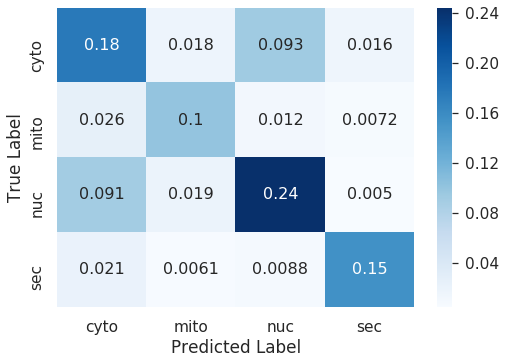

In [352]:
### Confusion Matrix ###
num_samples = len(y_test)
names = ['cyto', 'mito', 'nuc', 'sec']
df_cm = pd.DataFrame(cm/num_samples, names, names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues') # font size

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('cm.png')
plt.show()

Normalized confusion matrix
[[0.58 0.06 0.31 0.05]
 [0.18 0.69 0.08 0.05]
 [0.25 0.05 0.68 0.01]
 [0.11 0.03 0.05 0.81]]


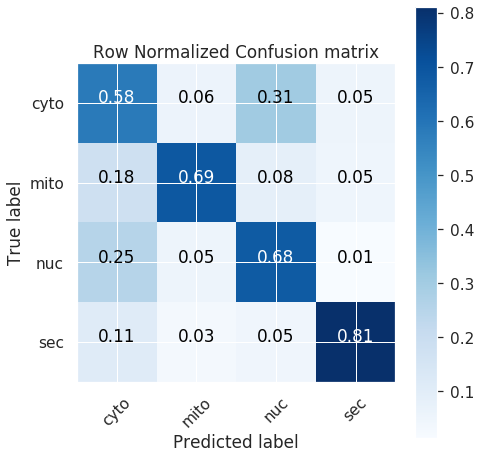

In [353]:
cnf_matrix =  confusion_matrix(y_test, y_pred_ensemble2)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['cyto','mito','nuc','sec'], normalize=True, title='Row Normalized Confusion matrix')
plt.show()

Confusion matrix, without normalization
[[321  32 169  29]
 [ 47 182  22  13]
 [165  35 442   9]
 [ 38  11  16 280]]


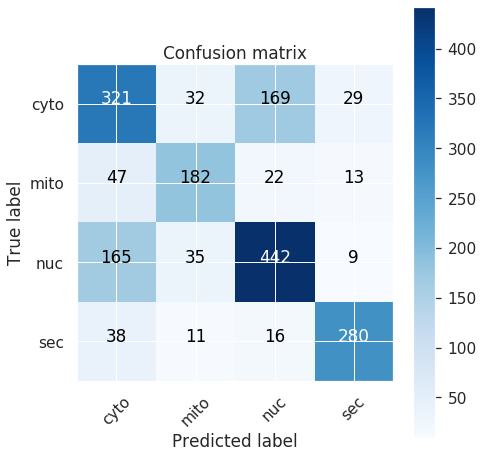

In [354]:
cnf_matrix =  confusion_matrix(y_test, y_pred_ensemble2)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['cyto','mito','nuc','sec'], normalize=False, title='Confusion matrix')
plt.show()

## Train Best Model From Above on Full Training Set

In [355]:
### Train best model from above ###

clf = clf_ensemble2

clf.fit(X_reduced, y)

VotingClassifier(estimators=[('SVM rbf',
                              SVC(C=1.0, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='auto_deprecated', kernel='rbf',
                                  max_iter=-1, probability=True,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False)),
                             ('LogReg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 inter...
                                                                          min_child_weight=4,
                                                                          missing=nan,
                                                     

## Predict on Blind Data

In [356]:
def load_blind_data(text_file):
    df = pd.DataFrame(columns=('ID',  
                               'Sequence_Length', 
                               'Molar_Extinction_Coefficient',
                               'Isoelectric_Point', 
                               'Aromaticity',
                               'Secondary_Structure_Helix',
                               'Secondary_Structure_Turn',
                               'Secondary_Structure_Sheet',
                               'Mean_Flexibility',
                               'Gravy',
                               'Molecular_Weight',
                               'Instability_Index',
                               'Ag', 'Cg', 'Dg', 'Eg', 'Fg',
                               'Gg', 'Hg', 'Ig', 'Kg', 'Lg',
                               'Mg', 'Ng', 'Pg', 'Qg', 'Rg',
                               'Sg', 'Tg', 'Vg', 'Wg', 'Yg',
                               'As', 'Cs', 'Ds', 'Es', 'Fs',
                               'Gs', 'Hs', 'Is', 'Ks', 'Ls',
                               'Ms', 'Ns', 'Ps', 'Qs', 'Rs',
                               'Ss', 'Ts', 'Vs', 'Ws', 'Ys',
                               'Ae', 'Ce', 'De', 'Ee', 'Fe',
                               'Ge', 'He', 'Ie', 'Ke', 'Le',
                               'Me', 'Ne', 'Pe', 'Qe', 'Re',
                               'Se', 'Te', 'Ve', 'We', 'Ye'))
 
    i=0 
    ID_list = []
    for seq_record in SeqIO.parse(text_file, "fasta"):
        # get sequence id
        seq_id = seq_record.id
        ID_list.append(seq_id)
        # get species
        #_, species = seq_id.split("_", 1)
        # get sequence length
        seq_len = len(seq_record)
        
        
        seq_rep = str(seq_record.seq)
        
        # locate offending characters
        B_list = [pos for pos, char in enumerate(seq_rep) if char == 'B']
        Z_list = [pos for pos, char in enumerate(seq_rep) if char == 'Z']
        X_list = [pos for pos, char in enumerate(seq_rep) if char == 'X']
        
        # replace "B" by asparagine ("N")/aspartic acid ("D")
        if len(B_list) != 0:
            print("B found at index {} in example {} of {}".format(B_list,i,text_file))
            for j in range(len(B_list)):
                flip = random.randint(0, 1)
                if flip == 1:
                    seq_rep = seq_rep[:B_list[j]] + 'N' + seq_rep[B_list[j]+1:]
                else:
                    seq_rep = seq_rep[:B_list[j]] + 'D' + seq_rep[B_list[j]+1:]
        # replace "Z" by glutamine ("Q")/glutamic acid ("E")
        if len(Z_list) != 0:
            print("Z found at index {} in example {} of {}".format(Z_list,i,text_file))
            for j in range(len(Z_list)):
                flip = random.randint(0, 1)
                if flip == 1:
                    seq_rep = seq_rep[:Z_list[j]] + 'Q' + seq_rep[Z_list[j]+1:]
                else:
                    seq_rep = seq_rep[:Z_list[j]] + 'E' + seq_rep[Z_list[j]+1:]
        
        # replace "U" by cysteine ("C")
        if len(B_list) != 0:
            print("U found at index {} in example {} of {}".format(U_list,i,text_file))
            for j in range(len(U_list)):
                seq_rep = seq_rep[:U_list[j]] + 'C' + seq_rep[U_list[j]+1:]
                
        # replace "X" by a random aminoa acid
        AA_alphabet = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
        if len(X_list) != 0:
            print("X found at index {} in example {} of {}".format(X_list,i,text_file))
            for j in range(len(Z_list)):
                flip = random.randint(0, 19)
                seq_rep = seq_rep[:X_list[j]] + AA_alphabet[flip] + seq_rep[X_list[j]+1:]
        
        
        
        # get analysed sequence and global count       
        analysed_seq = ProteinAnalysis(seq_rep)
        global_count = analysed_seq.count_amino_acids()
        
        # get N and C terminal amino acid sequences and counts
        analysed_start = ProteinAnalysis(seq_rep[:50])
        analysed_end = ProteinAnalysis(seq_rep[-50:])
        aa_start = analysed_start.count_amino_acids()
        aa_end = analysed_end.count_amino_acids()  
        
        
        # molar extinction coefficient
        molar = np.mean(analysed_seq.molar_extinction_coefficient())

        
        # isoelectric point
        isoelectric = analysed_seq.isoelectric_point() 
        # aromaticity
        aromaticity = analysed_seq.aromaticity()
        # secondary structure fraction
        helix, turn, sheet = analysed_seq.secondary_structure_fraction()    
        
        """Calculations below only possible if sequence doesn't have X so use try-except to set to Nan if there is an X"""   
                # gravy (grand average hydropathy)
        try:
            mean_flexibility = np.mean(analysed_seq.flexibility())
        except:
            mean_flexibility = float('NaN')
        # gravy (grand average hydropathy)
        try:
            gravy = analysed_seq.gravy()
        except:
            gravy = float('NaN')
        # molecular weight
        try:
            molecular_weight = analysed_seq.molecular_weight()
        except:
            molecular_weight = float('NaN')
        # instability index
        try:
            instability_idx = analysed_seq.instability_index()
        except:
            instability_idx = float('NaN')
            
        

        iso_s = analysed_start.isoelectric_point()         
        df.loc[i] = [seq_id,
                  seq_len,
                  molar,
                  isoelectric,
                  aromaticity,
                  helix,
                  turn,
                  sheet,
                  mean_flexibility,
                  gravy,
                  molecular_weight,
                  instability_idx,
                  global_count['A'],global_count['C'],global_count['D'],global_count['E'],global_count['F'],
                  global_count['G'],global_count['H'],global_count['I'],global_count['K'],global_count['L'],
                  global_count['M'],global_count['N'],global_count['P'],global_count['Q'],global_count['R'], 
                  global_count['S'],global_count['T'],global_count['V'],global_count['W'],global_count['Y'], 
                  aa_start['A'],aa_start['C'],aa_start['D'],aa_start['E'],aa_start['F'],
                  aa_start['G'],aa_start['H'],aa_start['I'],aa_start['K'],aa_start['L'],
                  aa_start['M'],aa_start['N'],aa_start['P'],aa_start['Q'],aa_start['R'], 
                  aa_start['S'],aa_start['T'],aa_start['V'],aa_start['W'],aa_start['Y'], 
                  aa_end['A'],aa_end['C'],aa_end['D'],aa_end['E'],aa_end['F'],
                  aa_end['G'],aa_end['H'],aa_end['I'],aa_end['K'],aa_end['L'],
                  aa_end['M'],aa_end['N'],aa_end['P'],aa_end['Q'],aa_end['R'], 
                  aa_end['S'],aa_end['T'],aa_end['V'],aa_end['W'],aa_end['Y']]
                     

        i+=1
        
        # ensure the sequence length column is of dtype int
        df.Sequence_Length = df.Sequence_Length.astype(int)
    print(i)
    return df, ID_list

In [357]:
# Load blind data
df_blind, ID_list = load_blind_data('blind.txt')

20


In [358]:
categorical_cols = ['ID']
df_blind = preprocess_data(df_blind,categorical_cols,seed)

-----Missing Features Before Imputation------
ID                              0
Sequence_Length                 0
Molar_Extinction_Coefficient    0
Isoelectric_Point               0
Aromaticity                     0
                               ..
Se                              0
Te                              0
Ve                              0
We                              0
Ye                              0
Length: 72, dtype: int64
-----Missing Features After Imputation------
ID                              0
Sequence_Length                 0
Molar_Extinction_Coefficient    0
Isoelectric_Point               0
Aromaticity                     0
                               ..
Se                              0
Te                              0
Ve                              0
We                              0
Ye                              0
Length: 72, dtype: int64


In [359]:
df_blind

,ID,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,...,Me,Ne,Pe,Qe,Re,Se,Te,Ve,We,Ye
0,6,-0.433239,-0.515963,1.151919,-0.868188,-0.410363,-0.268194,0.781389,0.224094,0.259319,...,-0.934405,0.048280,-0.330175,0.475002,-0.591843,0.271484,-0.902828,-0.816994,-0.712697,1.128152
1,2,-0.838955,-0.530375,-1.182085,0.560559,-0.100613,-0.706219,1.798115,-0.708992,1.006882,...,-0.934405,-0.917329,-0.718616,-1.108338,1.099137,-1.538407,0.844581,0.949480,1.069045,-0.483494
2,10,-0.729815,-0.207026,1.225676,0.683511,-0.356537,1.115924,-1.284450,-0.520519,-0.100817,...,-0.934405,1.496694,0.058266,-0.052778,-0.591843,0.271484,0.262111,-1.258612,0.178174,-0.483494
3,0,-0.390532,0.584023,-0.783093,2.682023,1.348737,-1.528675,-0.038853,-1.605862,-0.037508,...,0.164895,-0.434524,0.058266,1.530561,0.535477,-0.935110,-0.320358,-0.816994,1.069045,1.128152
4,13,0.413783,-0.425000,-1.115693,-1.055700,-0.904704,0.911975,-0.171175,1.234026,-0.803807,...,1.264194,1.496694,0.835148,1.530561,-0.591843,-0.331813,-0.902828,-0.375376,-0.712697,-1.289317
5,5,-0.516280,-0.765299,-0.359976,-1.306744,-1.880121,1.480231,-0.969447,1.361296,-2.034525,...,0.164895,0.048280,0.058266,2.058341,0.535477,-0.331813,-1.485297,0.507861,-0.712697,-0.483494
6,4,-0.141408,0.350531,-0.018720,0.136607,-0.132222,1.233746,-0.862837,-0.348423,-0.013456,...,0.164895,0.048280,-0.718616,-1.108338,-1.155503,-0.935110,-0.320358,2.274335,2.850787,1.933975
7,16,-0.962331,-0.855449,0.792799,-0.558551,-0.823612,0.148896,0.579369,0.024470,-0.076215,...,2.363494,-0.434524,0.058266,-0.052778,1.662797,-0.331813,-0.320358,-1.258612,0.178174,0.322329
8,19,-0.952841,-0.854636,-1.709162,-1.227487,-1.908166,0.314833,-2.034345,2.333899,-2.493635,...,-0.934405,-0.917329,-0.718616,0.475002,0.535477,0.874781,-0.902828,0.066243,-0.712697,-0.483494
9,11,0.537159,0.966453,1.560026,0.671040,0.630263,-0.712784,0.097624,-0.687514,0.308330,...,0.164895,0.048280,-0.330175,-1.108338,-0.028183,1.478078,0.262111,-0.816994,-0.712697,-0.483494


In [360]:
# drop the ID feature and other redundantg features
df_blind = df_blind.drop(columns=['ID'])
X_blind = df_blind.drop(columns=deselect)
X_blind 

,Sequence_Length,Molar_Extinction_Coefficient,Isoelectric_Point,Aromaticity,Secondary_Structure_Helix,Secondary_Structure_Turn,Secondary_Structure_Sheet,Mean_Flexibility,Gravy,Molecular_Weight,...,Me,Ne,Pe,Qe,Re,Se,Te,Ve,We,Ye
0,-0.433239,-0.515963,1.151919,-0.868188,-0.410363,-0.268194,0.781389,0.224094,0.259319,-0.458396,...,-0.934405,0.048280,-0.330175,0.475002,-0.591843,0.271484,-0.902828,-0.816994,-0.712697,1.128152
1,-0.838955,-0.530375,-1.182085,0.560559,-0.100613,-0.706219,1.798115,-0.708992,1.006882,-0.847695,...,-0.934405,-0.917329,-0.718616,-1.108338,1.099137,-1.538407,0.844581,0.949480,1.069045,-0.483494
2,-0.729815,-0.207026,1.225676,0.683511,-0.356537,1.115924,-1.284450,-0.520519,-0.100817,-0.719995,...,-0.934405,1.496694,0.058266,-0.052778,-0.591843,0.271484,0.262111,-1.258612,0.178174,-0.483494
3,-0.390532,0.584023,-0.783093,2.682023,1.348737,-1.528675,-0.038853,-1.605862,-0.037508,-0.320326,...,0.164895,-0.434524,0.058266,1.530561,0.535477,-0.935110,-0.320358,-0.816994,1.069045,1.128152
4,0.413783,-0.425000,-1.115693,-1.055700,-0.904704,0.911975,-0.171175,1.234026,-0.803807,0.387257,...,1.264194,1.496694,0.835148,1.530561,-0.591843,-0.331813,-0.902828,-0.375376,-0.712697,-1.289317
5,-0.516280,-0.765299,-0.359976,-1.306744,-1.880121,1.480231,-0.969447,1.361296,-2.034525,-0.511519,...,0.164895,0.048280,0.058266,2.058341,0.535477,-0.331813,-1.485297,0.507861,-0.712697,-0.483494
6,-0.141408,0.350531,-0.018720,0.136607,-0.132222,1.233746,-0.862837,-0.348423,-0.013456,-0.162065,...,0.164895,0.048280,-0.718616,-1.108338,-1.155503,-0.935110,-0.320358,2.274335,2.850787,1.933975
7,-0.962331,-0.855449,0.792799,-0.558551,-0.823612,0.148896,0.579369,0.024470,-0.076215,-0.954302,...,2.363494,-0.434524,0.058266,-0.052778,1.662797,-0.331813,-0.320358,-1.258612,0.178174,0.322329
8,-0.952841,-0.854636,-1.709162,-1.227487,-1.908166,0.314833,-2.034345,2.333899,-2.493635,-0.943760,...,-0.934405,-0.917329,-0.718616,0.475002,0.535477,0.874781,-0.902828,0.066243,-0.712697,-0.483494
9,0.537159,0.966453,1.560026,0.671040,0.630263,-0.712784,0.097624,-0.687514,0.308330,0.568182,...,0.164895,0.048280,-0.330175,-1.108338,-0.028183,1.478078,0.262111,-0.816994,-0.712697,-0.483494


In [361]:
# predict on blind data
y_probs = clf.predict_proba(X_blind)

In [362]:
y_probs

array([[3.42e-01, 9.69e-02, 5.45e-01, 1.60e-02],
       [4.18e-01, 3.38e-01, 1.58e-02, 2.28e-01],
       [3.14e-02, 4.65e-02, 1.67e-01, 7.55e-01],
       [5.00e-01, 6.19e-02, 4.04e-01, 3.43e-02],
       [4.12e-01, 3.85e-04, 5.87e-01, 1.06e-03],
       [2.28e-01, 9.10e-03, 7.44e-01, 1.89e-02],
       [1.10e-01, 3.21e-02, 1.46e-01, 7.11e-01],
       [2.20e-02, 1.68e-01, 1.84e-01, 6.26e-01],
       [1.79e-01, 3.38e-02, 7.49e-01, 3.77e-02],
       [2.97e-01, 4.77e-01, 2.17e-01, 9.46e-03],
       [5.20e-01, 8.46e-02, 2.86e-01, 1.10e-01],
       [5.69e-01, 6.85e-02, 3.49e-01, 1.33e-02],
       [7.46e-01, 1.59e-02, 2.36e-01, 1.78e-03],
       [2.24e-01, 1.67e-02, 7.56e-01, 2.73e-03],
       [6.43e-01, 9.27e-03, 8.37e-02, 2.64e-01],
       [1.67e-01, 3.53e-01, 4.72e-01, 7.75e-03],
       [5.13e-01, 1.16e-02, 4.75e-01, 5.66e-04],
       [5.01e-01, 5.97e-03, 4.40e-01, 5.25e-02],
       [5.13e-01, 1.49e-01, 3.36e-01, 2.02e-03],
       [4.52e-01, 1.51e-01, 2.66e-01, 1.31e-01]])

In [363]:
# Creating pandas dataframe from numpy array
prob_data = pd.DataFrame({'SEQ ID':ID_list,'cyto': y_probs[:, 0], 'mito': y_probs[:, 1], 'nuc': y_probs[:, 2], 'sec': y_probs[:, 3]})
prob_data

,SEQ ID,cyto,mito,nuc,sec
0,SEQ677,0.342121,0.096901,0.544929,0.016049
1,SEQ231,0.417735,0.338048,0.015849,0.228367
2,SEQ871,0.031388,0.046542,0.167224,0.754847
3,SEQ388,0.499552,0.061892,0.404229,0.034328
4,SEQ122,0.411901,0.000385,0.586656,0.001057
5,SEQ758,0.227540,0.009099,0.744499,0.018863
6,SEQ333,0.110427,0.032051,0.146313,0.711209
7,SEQ937,0.022010,0.167663,0.184420,0.625908
8,SEQ351,0.179313,0.033805,0.749226,0.037655
9,SEQ202,0.296682,0.477004,0.216856,0.009458


In [374]:
print(prob_data.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
 SEQ ID &      cyto &      mito &       nuc &       sec \\
\midrule
 SEQ677 &  0.342121 &  0.096901 &  0.544929 &  0.016049 \\
 SEQ231 &  0.417735 &  0.338048 &  0.015849 &  0.228367 \\
 SEQ871 &  0.031388 &  0.046542 &  0.167224 &  0.754847 \\
 SEQ388 &  0.499552 &  0.061892 &  0.404229 &  0.034328 \\
 SEQ122 &  0.411901 &  0.000385 &  0.586656 &  0.001057 \\
 SEQ758 &  0.227540 &  0.009099 &  0.744499 &  0.018863 \\
 SEQ333 &  0.110427 &  0.032051 &  0.146313 &  0.711209 \\
 SEQ937 &  0.022010 &  0.167663 &  0.184420 &  0.625908 \\
 SEQ351 &  0.179313 &  0.033805 &  0.749226 &  0.037655 \\
 SEQ202 &  0.296682 &  0.477004 &  0.216856 &  0.009458 \\
 SEQ608 &  0.520254 &  0.084634 &  0.285591 &  0.109521 \\
 SEQ402 &  0.568981 &  0.068475 &  0.349196 &  0.013348 \\
 SEQ433 &  0.745915 &  0.015914 &  0.236390 &  0.001781 \\
 SEQ821 &  0.224178 &  0.016668 &  0.756427 &  0.002727 \\
 SEQ322 &  0.643423 &  0.009268 &  0.083650 &  0.263660 \\
 SEQ982 &  0.16

In [364]:
# get prediction and its confidence
y_blind = []
y_conf = []

for idx in range(len(y_probs)):
    # predicted class is argmax
    a = np.argmax(y_probs[idx])
    y_blind.append(a)
    # confidence is corresponding y_probs value
    c = y_probs[idx,a]
    y_conf.append(c)

y_blind

[2, 0, 3, 0, 2, 2, 3, 3, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0]

In [365]:
names = ['cyto', 'mito', 'nuc', 'sec']
y_blind_names = []
for i in range(len(y_blind)):
    y_blind_names.append(names[y_blind[i]])

In [366]:
d = {'SEQ ID':ID_list,'Predicted Class':y_blind_names}

In [367]:
df_predictions = pd.DataFrame(d)

In [368]:
df_predictions['Confidence'] = y_conf

In [369]:
df_predictions

,SEQ ID,Predicted Class,Confidence
0,SEQ677,nuc,0.544929
1,SEQ231,cyto,0.417735
2,SEQ871,sec,0.754847
3,SEQ388,cyto,0.499552
4,SEQ122,nuc,0.586656
5,SEQ758,nuc,0.744499
6,SEQ333,sec,0.711209
7,SEQ937,sec,0.625908
8,SEQ351,nuc,0.749226
9,SEQ202,mito,0.477004


In [375]:
print(df_predictions.to_latex(index=False))

\begin{tabular}{llr}
\toprule
 SEQ ID & Predicted Class &  Confidence \\
\midrule
 SEQ677 &             nuc &    0.544929 \\
 SEQ231 &            cyto &    0.417735 \\
 SEQ871 &             sec &    0.754847 \\
 SEQ388 &            cyto &    0.499552 \\
 SEQ122 &             nuc &    0.586656 \\
 SEQ758 &             nuc &    0.744499 \\
 SEQ333 &             sec &    0.711209 \\
 SEQ937 &             sec &    0.625908 \\
 SEQ351 &             nuc &    0.749226 \\
 SEQ202 &            mito &    0.477004 \\
 SEQ608 &            cyto &    0.520254 \\
 SEQ402 &            cyto &    0.568981 \\
 SEQ433 &            cyto &    0.745915 \\
 SEQ821 &             nuc &    0.756427 \\
 SEQ322 &            cyto &    0.643423 \\
 SEQ982 &             nuc &    0.472001 \\
 SEQ951 &            cyto &    0.512998 \\
 SEQ173 &            cyto &    0.501497 \\
 SEQ862 &            cyto &    0.513225 \\
 SEQ224 &            cyto &    0.451742 \\
\bottomrule
\end{tabular}

